### Background
- Необходимость сократить время на осуществление относительно простых, но в тоже время рутинных и часто возникающих CFD-расчетов трубопроводов различного назначения

### Purpose
- Оценить состоятельность и эффективность применения Deep Convolutional Neural Networks для решения поставленной задачи, а также общие трудо- и время- затраты (на обучение модели и т.д.)
- Применить полученные на курсе знания и навыки для решения практической (насущной) задачи
- Получить новый опыт

---
- `FinalProject_ModelListGeneration.py` - скрипт генерации параметров геометрии CFD моделей
- `FinalProject_CadModelGeneration.ipynb` - скрипт генерации CAD моделей по параметрам
- `FinalProject_CfdModelGeneration.FCMacro` - скрипт генерации CFD моделей из CAD
- `runALLAllmesh`, `runALLAllrun` - скрипты запуска генерации расчетной сетки и запуска CFD расчета
- `FinalProject_GettingResults_v1.py` - скрипт извлечения результатов



[DATA EXAMPLES](https://drive.google.com/drive/folders/1BUo5T81UsoqGpVlbbAevScY0er5NXZrp?usp=sharing)

---

In [ ]:
# from platform import python_version

# print(python_version())

In [1]:
# libraries importing
import os, glob, itertools, re, pickle, json, random, math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from tqdm import tqdm, trange

from PIL import Image
import cv2

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

from FinalProject_ModelListGeneration import get_models_list

In [2]:
# environment setting
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
DATA_PATH = 'D:\\DataScience\\FinalProject\\cfd_results\\10mm'

## Data importing

### Tabular data

In [ ]:
# # getting list with models parameters
# models = get_models_list()

# models = models[models['diameter']==10]
# models.reset_index(drop=True, inplace=True)
# models.drop(columns=['diameter'], inplace=True)

# display(models.head(3), models.shape)

In [ ]:
# # getting cfd-analysis tabular results data
# tables_list = glob.glob(os.path.join(DATA_PATH, '*', '*.csv'))

# for i, table in enumerate(tables_list):
#     if i == 0:
#         results = pd.read_csv(table)
#     else:
#         results = results.append(pd.read_csv(table), ignore_index=True)

# display(results.head(3), results.shape)

In [ ]:
# # concatenate data (parameters + cfd-results)
# models = models.merge(results, how='right', on='description')

# display(models.head(3), models.shape)

#### Preprocessing

- Для обучения нейросети будем использовать отдельно каждую "секцию" по отдельности со своими распределениями скоростей и давления на входном и выходном сечениях. Так же "дадим модели знать" о параметрах предыдущей и последующей секциях.

In [ ]:
# # list of necessary data for learning
# data = {'before_size':[],
#         'before_shape':[],
#         'before_direction':[],
#         'current_size':[],
#         'current_shape':[],
#         'current_direction':[],
#         'after_size':[],
#         'after_shape':[],
#         'after_direction':[],
#         'inlet-P_min':[],
#         'inlet-P_max':[],
#         'inlet-UX_min':[],
#         'inlet-UX_max':[],
#         'inlet-UY_min':[],
#         'inlet-UY_max':[],
#         'inlet-UZ_min':[],
#         'inlet-UZ_max':[],
#         'outlet-P_min':[],
#         'outlet-P_max':[],
#         'outlet-UX_min':[],
#         'outlet-UX_max':[],
#         'outlet-UY_min':[],
#         'outlet-UY_max':[],
#         'outlet-UZ_min':[],
#         'outlet-UZ_max':[]
#        }

In [ ]:
# # getting each section of model as one data row
# for i in range(len(models)):
    
#     section_count = int((len(models['description'][i].split('-'))-1)/3)
    
#     '''
#     Getting parameters of current section and also previous and next sections.
#     If section is first or last set 0 for the all parameters of
#     previous or next section respectively.
#     '''
#     for j in range(section_count):
#         for x in range(0,7,3):
#             for y,column in enumerate(list(data.keys())[x:x+3]):
#                 if x == 3:
#                     data[column].append(models.iloc[i, j+3*y])
#                 elif x == 0:
#                     if j == section_count-1 or j == 0:
#                         data[column].append(0)
#                     else:
#                         data[column].append(models.iloc[i, j-1+3*y])
#                 else:
#                     if j == section_count-1:
#                         data[column].append(0)
#                     else:
#                         data[column].append(models.iloc[i, j+1+3*y])
        
#         '''
#         Getting results of section INLET and OUTLET
#         '''
#         inlet_idx = 's'+str(j)
#         outlet_idx = 's'+str(j+1)
        
#         d = {'inlet':inlet_idx,
#              'outlet':outlet_idx}
        
#         cnt = 0
        
#         for column in list(data.keys())[9:25]:
#             cnt += 1
#             result = column.split('-')
#             data[column].append(models[d[result[0]]+'-'+result[1]][i])
            
#             ## getting path to images 
#             if cnt % 2 == 0:
#                 result[1] = result[1].split('_')[0]
                
#                 new_column = result[0]+'-'+result[1]+'_image'
#                 img_name = d[result[0]]+'-'+result[1]+'.png'
#                 path2img = glob.glob(os.path.join(DATA_PATH, '*', models['description'][i], img_name))[0]
                
#                 if new_column not in list(data.keys()):
#                     data[new_column] = []
#                 data[new_column].append(path2img)

In [ ]:
# df = pd.DataFrame(data)

# display(df.head(3), df.shape)

In [ ]:
# df.info()

In [ ]:
# # Lable encoding
# encoder = LabelEncoder()

# for column in list(df.columns)[:-int(cnt/2)]:
#     if df[column].dtypes == 'O':
#         df[column] = df[column].apply(str)
#         df[column] = encoder.fit_transform(df[column])

# display(df.head(3), df.shape)

- Дабы при каждом перезапуске не проводить преобразование выше, сохраним датафрейм и далее будем подгружат данные из него

In [ ]:
# df.to_csv(os.path.join('D:/DataScience/FinalProject', 'data.csv'), index=False)

In [4]:
df = pd.read_csv(os.path.join('D:/DataScience/FinalProject', 'data.csv'))
display(df.head(3), df.shape)

before_size  before_shape  before_direction  current_size  current_shape  \
0            0             0                 0         100.0              0   
1            0             0                 0         100.0              1   
2            0             0                 0         100.0              2   

   current_direction  after_size  after_shape  after_direction  inlet-P_min  \
0                  1         0.0            0                0     2.883144   
1                  1         0.0            0                0    15.469522   
2                  1         0.0            0                0    12.722014   

   inlet-P_max  inlet-UX_min  inlet-UX_max  inlet-UY_min  inlet-UY_max  \
0    23.250622     -0.000076      0.000062     -0.000057      0.000062   
1    31.255623      0.000000      0.000000      0.000000      0.000000   
2    17.040760      0.000000      0.000000      0.000000      0.000000   

   inlet-UZ_min  inlet-UZ_max  outlet-P_min  outlet-P_max  outlet-UX_min  \
0     10.649561     10.649561           0.0           0.0       3.521138   
1     10.645368     10.645368           0.0           0.0       3.197995   
2     10.645036     10.645036           0.0           0.0      -0.028793   

   outlet-UX_max  outlet-UY_min  outlet-UY_max  outlet-UZ_min  outlet-UZ_max  \
0       7.946285      -0.548229       0.546499       3.477491       8.726934   
1      12.199653      -0.741741       0.741699      -1.062204       0.769829   
2       0.026809      -0.028804       0.026948       6.384067      11.541277   

                                       inlet-P_image  \
0  D:\DataScience\FinalProject\cfd_results\10mm\1...   
1  D:\DataScience\FinalProject\cfd_results\10mm\1...   
2  D:\DataScience\FinalProject\cfd_results\10mm\1...   

                                      inlet-UX_image  \
0  D:\DataScience\FinalProject\cfd_results\10mm\1...   
1  D:\DataScience\FinalProject\cfd_results\10mm\1...   
2  D:\DataScience\FinalProject\cfd_results\10mm\1...   

                                      inlet-UY_image  \
0  D:\DataScience\FinalProject\cfd_results\10mm\1...   
1  D:\DataScience\FinalProject\cfd_results\10mm\1...   
2  D:\DataScience\FinalProject\cfd_results\10mm\1...   

                                      inlet-UZ_image  \
0  D:\DataScience\FinalProject\cfd_results\10mm\1...   
1  D:\DataScience\FinalProject\cfd_results\10mm\1...   
2  D:\DataScience\FinalProject\cfd_results\10mm\1...   

                                      outlet-P_image  \
0  D:\DataScience\FinalProject\cfd_results\10mm\1...   
1  D:\DataScience\FinalProject\cfd_results\10mm\1...   
2  D:\DataScience\FinalProject\cfd_results\10mm\1...   

                                     outlet-UX_image  \
0  D:\DataScience\FinalProject\cfd_results\10mm\1...   
1  D:\DataScience\FinalProject\cfd_results\10mm\1...   
2  D:\DataScience\FinalProject\cfd_results\10mm\1...   

                                     outlet-UY_image  \
0  D:\DataScience\FinalProject\cfd_results\10mm\1...   
1  D:\DataScience\FinalProject\cfd_results\10mm\1...   
2  D:\DataScience\FinalProject\cfd_results\10mm\1...   

                                     outlet-UZ_image  
0  D:\DataScience\FinalProject\cfd_results\10mm\1...  
1  D:\DataScience\FinalProject\cfd_results\10mm\1...  
2  D:\DataScience\FinalProject\cfd_results\10mm\1...

(6024, 33)

In [ ]:
df.info()

In [ ]:
rslt = list(df.columns)[9:-8]

n_rslt = len(rslt)

fig, axs = plt.subplots(int(n_rslt/2), 2, figsize=(20, n_rslt*3))

for i, j in enumerate(rslt):
    min_value=round(df[j].min(), 1)
    max_value=round(df[j].max(), 1)

    axs[i//2][i%2].hist(df[j], bins='auto')
    axs[i//2][i%2].set_title(f'{j}: Min.val.={min_value}, Max.val.={max_value}')
    axs[i//2][i%2].grid(True, axis='y', alpha=0.5)
    axs[i//2][i%2].set_ylabel('Count')

### Image data

In [ ]:
def get_img_samples(n_smpl=5, df=df, s_sart=-8, s_end=None):

    plt.figure(figsize=(20, n_smpl*2))

    for i, (x, y) in enumerate(itertools.product(df.sample(n_smpl).index, list(df.columns)[s_sart:s_end])):
        file_name = df[y][x]
        img = Image.open(file_name)
        plt.subplot(n_smpl, 8, i+1)
        plt.imshow(img)
        plt.title(f"{x}-{y}")
        plt.axis('off')

    plt.show()

In [ ]:
get_img_samples()

#### Preprocessing

In [ ]:
img_path = df['inlet-P_image'][2924]
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
# plt.figure(figsize=(20,20))
plt.imshow(img, cmap='gray')
plt.colorbar()

In [ ]:
np.unique(img)

In [ ]:
print(f"Max.val.= {df['inlet-P_max'][2924]},\nMin.val.= {df['inlet-P_min'][2924]}")

In [5]:
def get_preprocessed_image(column, row, ratio=4, df=df, save=False, data_path=DATA_PATH):
    
    '''loading image'''
    img_path = df[column][row]
    # as single channel image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # downsizing
    img_h, img_w = img.shape
    assert img_h % ratio == 0 and img_w % ratio == 0, 'Image size must be even divisible by resizing ratio'
    new_size = (img_w//ratio, img_h//ratio)
    img_changed = cv2.resize(img, new_size, interpolation=cv2.INTER_NEAREST)
    
    # normalize pixels value (optional)
    img_changed = img_changed/255

    '''scaling'''
    img_h, img_w = img_changed.shape
    # values range
    max_val = df[column.replace('image', 'max')][row]
    min_val = df[column.replace('image', 'min')][row]
    # pixels value range
    max_val_px = np.unique(img_changed)[-1]
    min_val_px = np.unique(img_changed)[1]

    '''set real value as pixel grey value'''
    for h, w in list(itertools.product(range(img_h), range(img_w))):
        '''
        If a pixel has a value of 0, it means that it is outside the pipe cross section
        Set it to the value of atmospheric pressure, in the case of CFD analysis equal to 0.
        '''
        if img_changed.item(h, w) != 0:
            real_val = (img_changed.item(h, w)-min_val_px)\
                        * (max_val-min_val)/(max_val_px-min_val_px) + min_val
        else:
            real_val = 0

        img_changed.itemset((h, w), real_val / 127.5)

    '''saving preprocessed image, if required'''
    if save:
        found_names = re.findall(r"\d+.+?[^\\]*", img_path)
        batch_name = found_names[1]
        model_name = found_names[2]
        img_name = os.path.basename(img_path)

        save_path = os.path.join(data_path.replace('cfd_results', 'img_preprocessing'),
                                 batch_name,
                                 model_name)
        os.makedirs(save_path, exist_ok=True)
        '''
        The adding 127.5 to each pixel shifts the zero to a mid-grey value,
        shows negative values as darker, and positive values as lighter.
        '''
        cv2.imwrite(os.path.join(save_path, img_name), img_changed + 127.5)

    return np.array(img_changed.astype('float32')), img_h, img_w

---
##### Checking function work

In [ ]:
img_changed, _, _ = get_preprocessed_image(column='inlet-P_image',
                                           row=2924)

# plt.figure(figsize=(20,20))
plt.imshow(img_changed, cmap='gray')
plt.colorbar()

In [ ]:
np.unique(img_changed)

---

In [ ]:
# Lable encoding
encoder = LabelEncoder()

for column in list(df.columns):
    if 'size' in column:
        df[column] = df[column].apply(int)
        df[column] = encoder.fit_transform(df[column])

display(df.head(3), df.shape)

In [ ]:
# def get_geom_channel(row, df=df, img_h=512, img_w=512):
    
#     h = img_h//3 + 1
#     w = img_w//3 + 1
    
#     '''create filled with zeros array'''
#     s = (img_h, img_w)
#     geom_param = np.zeros(s)
    
#     '''fill by previous geom'''
#     geom_param[:] = df[list(df.columns)[0]][row]
#     geom_param[:,w:] = df[list(df.columns)[1]][row]
#     geom_param[:,-w:] = df[list(df.columns)[2]][row]
    
#     '''fill by current geom'''
#     geom_param[h:] = df[list(df.columns)[3]][row]
#     geom_param[h:,w:] = df[list(df.columns)[4]][row]
#     geom_param[h:,-w:] = df[list(df.columns)[5]][row]
    
#     '''fill by next geom'''
#     geom_param[-h:] = df[list(df.columns)[6]][row]
#     geom_param[-h:,w:] = df[list(df.columns)[7]][row]
#     geom_param[-h:,-w:] = df[list(df.columns)[8]][row]
    
#     return geom_param.astype('float32')

In [6]:
def get_geom_channel(row, df=df, img_h=512, img_w=512):
    
    s = (img_h, img_w)
    geom_param = np.zeros(s)
    
    for (h, w), i in zip(itertools.product(range(img_h), range(img_w)), itertools.cycle(list(df.columns)[:9])):
        geom_param.itemset((h, w), df[i][row])
    
    return geom_param.astype('float32')

---
##### Checking function work

In [ ]:
df.iloc[2924]

In [ ]:
geom_param = get_geom_channel(2924)

# plt.figure(figsize=(20,20))
plt.imshow(geom_param, cmap='gray')
plt.colorbar()

In [ ]:
np.unique(geom_param)

---
## Dataset preparing

In [ ]:
def get_channels_set(column_list, row, df=df, with_geom=True):
    
    channels_set = []
    
    for column in column_list:
        value_channel, img_h, img_w = get_preprocessed_image(column=column,
                                                             row=row,
                                                             df=df)
        channels_set.append(value_channel)
    
    if with_geom:
        geom_channel = get_geom_channel(row=row,
                                        df=df,
                                        img_h=img_h,
                                        img_w=img_w)
        channels_set.append(geom_channel)

    return channels_set

In [ ]:
dataset_lists = {'dataX_model_V':[['inlet-UX_image',
                                   'inlet-UY_image',
                                   'inlet-UZ_image'], True],
                 
                 'dataX_model_P':[['outlet-P_image',
                                   'inlet-UX_image',
                                   'inlet-UY_image',
                                   'inlet-UZ_image'], False],
                 
                 'dataY_model_V':[['outlet-UX_image',
                                   'outlet-UY_image',
                                   'outlet-UZ_image'], False],
                 
                 'dataY_model_P':[['inlet-P_image'], False]}

In [ ]:
for ds in list(dataset_lists.keys()):

    data = Parallel(n_jobs=-1)(delayed(get_channels_set)(column_list=dataset_lists[ds][0],
                                                         with_geom=dataset_lists[ds][1],
                                                         row=row) for row in trange(len(df)))
    f = open(ds + '.pkl', 'wb')
    pickle.dump(data, f)
    f.close()
    del data

---
##### Checking function work

In [ ]:
x = pickle.load(open("dataX_model_V.pkl", "rb"))

plt.figure(figsize=(20,4))

for i in range(len(x[0])):
    plt.subplot(1, len(x[0]), i+1)
    plt.imshow(x[2924][i], cmap='gray')
    plt.colorbar()

---

# DCNN

In [7]:
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm

import copy

In [8]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2060 with Max-Q Design (UUID: GPU-05df1c92-ad9b-711e-a79e-eaa2ef54918a)


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(RANDOM_SEED)

### Helper functions

In [10]:
def split_tensors(*tensors, ratio):
    assert len(tensors) > 0
    split1, split2 = [], []
    count = len(tensors[0])
    for tensor in tensors:
        assert len(tensor) == count
        split1.append(tensor[:int(len(tensor) * ratio)])
        split2.append(tensor[int(len(tensor) * ratio):])
    if len(tensors) == 1:
        split1, split2 = split1[0], split2[0]
    return split1, split2

In [11]:
def create_layer(in_channels,
                 out_channels,
                 kernel_size,
                 wn=True,
                 bn=True,
                 activation=nn.ReLU,
                 convolution=nn.Conv2d):

    assert kernel_size % 2 == 1
    layer = []
    conv = convolution(in_channels,
                       out_channels,
                       kernel_size,
                       padding=kernel_size//2)
    if wn:
        conv = weight_norm(conv)
    
    layer.append(conv)
    
    if activation is not None:
        layer.append(activation())
    
    if bn:
        layer.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layer)

In [12]:
def create_encoder_block(in_channels,
                         out_channels,
                         kernel_size,
                         wn=True,
                         bn=True,
                         activation=nn.ReLU,
                         layers=2):
    
    encoder = []
    for i in range(layers):
        _in = out_channels
        _out = out_channels
        if i == 0:
            _in = in_channels
        encoder.append(create_layer(_in, _out, kernel_size, wn, bn, activation, nn.Conv2d))
    return nn.Sequential(*encoder)

In [13]:
def create_decoder_block(in_channels,
                         out_channels,
                         kernel_size,
                         wn=True,
                         bn=True,
                         activation=nn.ReLU,
                         layers=2,
                         final_layer=False):
    
    decoder = []
    for i in range(layers):
        _in = in_channels
        _out = in_channels
        _bn = bn
        _activation = activation
        if i == 0:
            _in = in_channels * 2
        if i == layers - 1:
            _out = out_channels
            if final_layer:
                _bn = False
                _activation = None
        decoder.append(create_layer(_in, _out, kernel_size, wn, _bn, _activation, nn.ConvTranspose2d))
    return nn.Sequential(*decoder)

In [14]:
def create_encoder(in_channels,
                   filters,
                   kernel_size,
                   wn=True,
                   bn=True,
                   activation=nn.ReLU,
                   layers=2):
    
    encoder = []
    for i in range(len(filters)):
        if i == 0:
            encoder_layer = create_encoder_block(in_channels,
                                                 filters[i],
                                                 kernel_size,
                                                 wn,
                                                 bn,
                                                 activation,
                                                 layers)
        else:
            encoder_layer = create_encoder_block(filters[i-1],
                                                 filters[i],
                                                 kernel_size,
                                                 wn,
                                                 bn,
                                                 activation,
                                                 layers)
        encoder = encoder + [encoder_layer]
    return nn.Sequential(*encoder)

In [15]:
def create_decoder(out_channels,
                   filters,
                   kernel_size,
                   wn=True,
                   bn=True,
                   activation=nn.ReLU,
                   layers=2):
    
    decoder = []
    for i in range(len(filters)):
        if i == 0:
            decoder_layer = create_decoder_block(filters[i],
                                                 out_channels,
                                                 kernel_size,
                                                 wn,
                                                 bn,
                                                 activation,
                                                 layers,
                                                 final_layer=True)
        else:
            decoder_layer = create_decoder_block(filters[i],
                                                 filters[i-1],
                                                 kernel_size,
                                                 wn,
                                                 bn,
                                                 activation,
                                                 layers,
                                                 final_layer=False)
        decoder = [decoder_layer] + decoder
    return nn.Sequential(*decoder)

In [16]:
def initialize(model, gain=1, std=0.02):
    for module in model.modules():
        if type(module) in [nn.Linear, nn.Conv1d, nn.Conv2d, nn.Conv3d]:
            nn.init.xavier_normal_(module.weight, gain)
            if module.bias is not None:
                nn.init.normal_(module.bias, 0, std)

In [17]:
def epoch(scope, loader, on_batch=None, training=False):
    model = scope["model"]
    optimizer = scope["optimizer"]
    loss_func = scope["loss_func"]
    metrics_def = scope["metrics_def"]
    scope = copy.copy(scope)
    scope["loader"] = loader

    metrics_list = generate_metrics_list(metrics_def)
    total_loss = 0
    if training:
        model.train()
    else:
        model.eval()
    for tensors in loader:
        
        if "process_batch" in scope and scope["process_batch"] is not None:
            tensors = scope["process_batch"](tensors)
        if "device" in scope and scope["device"] is not None:
            tensors = [tensor.to(scope["device"]) for tensor in tensors]
            
        loss, output = loss_func(model, tensors)
        
        if training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        total_loss += loss.item()
        
        scope["batch"] = tensors
        scope["loss"] = loss
        scope["output"] = output
        scope["batch_metrics"] = {}
        
        for name, metric in metrics_def.items():
            value = metric["on_batch"](scope)
            scope["batch_metrics"][name] = value
            metrics_list[name].append(value)
        if on_batch is not None:
            on_batch(scope)
    scope["metrics_list"] = metrics_list
    metrics = {}
    for name in metrics_def.keys():
        scope["list"] = scope["metrics_list"][name]
        metrics[name] = metrics_def[name]["on_epoch"](scope)
    return total_loss, metrics

In [18]:
def train(scope,
          train_dataset,
          val_dataset,
          patience=10,
          batch_size=256,
          print_function=print,
          eval_model=None,
          on_train_batch=None,
          on_val_batch=None,
          on_train_epoch=None,
          on_val_epoch=None,
          after_epoch=None):
    
    epochs = scope["epochs"]
    model = scope["model"]
    metrics_def = scope["metrics_def"]
    scope = copy.copy(scope)

    scope["best_train_metric"] = None
    scope["best_train_loss"] = float("inf")
    scope["best_val_metrics"] = None
    scope["best_val_loss"] = float("inf")
    scope["best_model"] = None

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    skips = 0
    
    for epoch_id in range(1, epochs + 1):
        scope["epoch"] = epoch_id
        print_function("Epoch #" + str(epoch_id))
        
        # Training
        scope["dataset"] = train_dataset
        train_loss, train_metrics = epoch(scope, train_loader, on_train_batch, training=True)
        scope["train_loss"] = train_loss
        scope["train_metrics"] = train_metrics
        print_function("\tTrain Loss = " + str(train_loss))
        
        for name in metrics_def.keys():
            print_function("\tTrain " + metrics_def[name]["name"] + " = " + str(train_metrics[name]))
        if on_train_epoch is not None:
            on_train_epoch(scope)
        del scope["dataset"]
        
        # Validation
        scope["dataset"] = val_dataset
        with torch.no_grad():
            val_loss, val_metrics = epoch(scope, val_loader, on_val_batch, training=False)
        scope["val_loss"] = val_loss
        scope["val_metrics"] = val_metrics
        print_function("\tValidation Loss = " + str(val_loss))
        
        for name in metrics_def.keys():
            print_function("\tValidation " + metrics_def[name]["name"] + " = " + str(val_metrics[name]))
        if on_val_epoch is not None:
            on_val_epoch(scope)
        del scope["dataset"]
        
        # Selection
        is_best = None
        if eval_model is not None:
            is_best = eval_model(scope)
        if is_best is None:
            is_best = val_loss < scope["best_val_loss"]
        if is_best:
            scope["best_train_metric"] = train_metrics
            scope["best_train_loss"] = train_loss
            scope["best_val_metrics"] = val_metrics
            scope["best_val_loss"] = val_loss
            scope["best_model"] = copy.deepcopy(model)
            print_function("Model saved!")
            skips = 0
        else:
            skips += 1
        if after_epoch is not None:
            after_epoch(scope)

    return scope["best_model"],\
           scope["best_train_metric"],\
           scope["best_train_loss"],\
           scope["best_val_metrics"],\
           scope["best_val_loss"]

In [19]:
def train_model(model,
                loss_func,
                train_dataset,
                val_dataset,
                optimizer,
                process_batch=None,
                eval_model=None,
                on_train_batch=None,
                on_val_batch=None,
                on_train_epoch=None,
                on_val_epoch=None,
                after_epoch=None,
                epochs=100,
                batch_size=256,
                patience=10,
                device=0,
                **kwargs):
    
    model = model.to(device)
    
    scope = {}
    scope["model"] = model
    scope["loss_func"] = loss_func
    scope["train_dataset"] = train_dataset
    scope["val_dataset"] = val_dataset
    scope["optimizer"] = optimizer
    scope["process_batch"] = process_batch
    scope["epochs"] = epochs
    scope["batch_size"] = batch_size
    scope["device"] = device
    metrics_def = {}
    names = []
    
    for key in kwargs.keys():
        parts = key.split("_")
        if len(parts) == 3 and parts[0] == "m":
            if parts[1] not in names:
                names.append(parts[1])
    
    for name in names:
        if "m_" + name + "_name" in kwargs and "m_" + name + "_on_batch" in kwargs and "m_" + name + "_on_epoch" in kwargs:
            metrics_def[name] = {
                "name": kwargs["m_" + name + "_name"],
                "on_batch": kwargs["m_" + name + "_on_batch"],
                "on_epoch": kwargs["m_" + name + "_on_epoch"],
            }
        else:
            print("Warning: " + name + " metric is incomplete!")
    scope["metrics_def"] = metrics_def
    
    return train(scope,
                 train_dataset,
                 val_dataset,
                 eval_model=eval_model,
                 on_train_batch=on_train_batch,
                 on_val_batch=on_val_batch,
                 on_train_epoch=on_train_epoch,
                 on_val_epoch=on_val_epoch,
                 after_epoch=after_epoch,
                 batch_size=batch_size,
                 patience=patience)

In [20]:
def generate_metrics_list(metrics_def):
    list = {}
    for name in metrics_def.keys():
        list[name] = []
    return list

In [21]:
def visualize(sample_y, out_y, error):
    
    var_list = [sample_y, out_y, error]
    title_list = ['CFD', 'CNN', 'Error']
    lable_list = ['Ux', 'Uy', 'Uz']

    output_size = len(out_y) #10
    output_channels = len(out_y[0]) #3

    smpl = random.randint(0, output_size-1)
    
    print(f'Sampled model number: {smpl}')

    plt.figure(figsize=(20, output_channels*5))
    
    cnt = 0

    for i in range(output_channels):

        vmin_sample = np.min(sample_y[smpl, i, :, :])
        vmax_sample = np.max(sample_y[smpl, i, :, :])

        vmin_out = np.min(out_y[smpl, i, :, :])
        vmax_out = np.max(out_y[smpl, i, :, :])
        
        vmin_error = np.min(error[smpl, i, :, :])
        vmax_error = np.max(error[smpl, i, :, :])

        for j in range(3):
            
            cnt += 1

            plt.subplot(output_channels, 3, cnt)
            
            if j == 0:
                if output_channels > 1:
                    plt.ylabel(f'{lable_list[i]}', fontsize=18)
                else:
                    plt.ylabel('P', fontsize=18)
            
            if j != 2:
                vmin = min(vmin_sample, vmin_out)
                vmax = max(vmax_sample, vmax_out)
            else:
                vmin = vmin_error
                vmax = vmax_error
            
            plt.imshow(np.transpose(var_list[j][smpl, i, :, :]),
                       vmin = vmin,
                       vmax = vmax)
            
            plt.colorbar()#.ax.tick_params(labelsize=18)
            
            if i == 0:
                plt.title(f'{title_list[j]}', fontsize=18)
    
    if output_channels > 1:
        model_name = 'ModelV'
    else:
        model_name = 'ModelP'
    
    plt.savefig(simulation_directory + 'sample' + str(smpl)+ '_' + model_name + '.png')
    plt.show()

## Model V

##### "Velocity to Velocity"

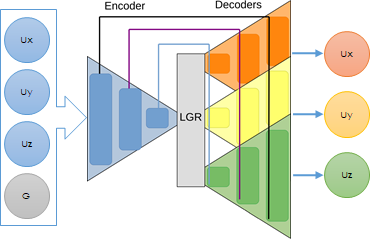

In [22]:
class UNetEx(nn.Module):
    
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 filters=[16, 32, 64],
                 layers=3,
                 weight_norm=True,
                 batch_norm=True,
                 activation=nn.ReLU,
                 final_activation=None):
        
        super().__init__()
        assert len(filters) > 0
        self.final_activation = final_activation
        self.encoder = create_encoder(in_channels,
                                      filters,
                                      kernel_size,
                                      weight_norm,
                                      batch_norm,
                                      activation,
                                      layers)
        
        decoders = []
        for i in range(out_channels):
            decoders.append(create_decoder(1,
                                           filters,
                                           kernel_size,
                                           weight_norm,
                                           batch_norm,
                                           activation,
                                           layers))
            
        self.decoders = nn.Sequential(*decoders)

    def encode(self, x):
        tensors = []
        indices = []
        sizes = []
        
        for encoder in self.encoder:
            x = encoder(x)
            sizes.append(x.size())
            tensors.append(x)
            x, ind = F.max_pool2d(x, 2, 2, return_indices=True)
            indices.append(ind)
        
        return x, tensors, indices, sizes

    def decode(self, _x, _tensors, _indices, _sizes):
        
        y = []
        
        for _decoder in self.decoders:
            x = _x
            tensors = _tensors[:]
            indices = _indices[:]
            sizes = _sizes[:]
            for decoder in _decoder:
                tensor = tensors.pop()
                size = sizes.pop()
                ind = indices.pop()
                x = F.max_unpool2d(x, ind, 2, 2, output_size=size)
                x = torch.cat([tensor, x], dim=1)
                x = decoder(x)
            y.append(x)
            
        return torch.cat(y, dim=1)

    def forward(self, x):
        x, tensors, indices, sizes = self.encode(x)
        x = self.decode(x, tensors, indices, sizes)
        if self.final_activation is not None:
            x = self.final_activation(x)
        
        return x

In [23]:
def loss_func(model, batch):
    x, y = batch
    output = model(x)
    
    mse_loss = nn.MSELoss()
    
    loss = 0
    
    for i in range(len(y[0])):
        loss += mse_loss(output[:,i,:,:], y[:,i,:,:])
        
    loss = (loss)/channels_weights
    
    return torch.sum(loss), output
    
#     if len(y[0]) > 1:
# #         # MSE written by authors of project
# #         lossu = ((output[:,0,:,:] - y[:,0,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3]))
# #         lossv = ((output[:,1,:,:] - y[:,1,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3]))
# #         lossz = ((output[:,2,:,:] - y[:,2,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3]))
#         # changed to pyTorch function
#         lossu = mse_loss(output[:,0,:,:], y[:,0,:,:])
#         lossv = mse_loss(output[:,1,:,:], y[:,1,:,:])
#         lossz = mse_loss(output[:,2,:,:], y[:,2,:,:])
        
#     loss = (lossu + lossv + lossz)/channels_weights
    
#     else:
#         # MAE written by authors of project
#         loss = torch.abs((output[:,0,:,:] - y[:,0,:,:])).reshape((output.shape[0],1,output.shape[2],output.shape[3])) 

In [24]:
DATA_X_PATH = "D:/DataScience/FinalProject/dataX_model_V.pkl"
DATA_Y_PATH = "D:/DataScience/FinalProject/dataY_model_V.pkl"

# Loading dataset
x = pickle.load(open(DATA_X_PATH, "rb"))
y = pickle.load(open(DATA_Y_PATH, "rb"))

assert len(x) == len(y)

# Shuffling dataset
dataset_size = len(x)
indices = list(range(dataset_size))
np.random.shuffle(indices)
x = np.array(x)[indices]
y = np.array(y)[indices]

In [25]:
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)

x_Ns, x_Nc, x_Nx, x_Ny = x.shape
y_Ns, y_Nc, y_Nx, y_Ny = y.shape

# channels_weights = torch.sqrt(torch.mean(y.permute(0, 2, 3, 1)\
#                                          .reshape((y_Ns*y_Nx*y_Ny, y_Nc)) ** 2, dim=0)).view(1, -1, 1, 1).to(device)

# print(channels_weights)

channels_weights = 1

In [26]:
# Spliting dataset into 70% train and 30% test
train_data, test_data = split_tensors(x, y, ratio=0.7)

train_dataset, test_dataset = TensorDataset(*train_data), TensorDataset(*test_data)        
test_x, test_y = test_dataset[:]

In [27]:
simulation_directory = "./Run/"
if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)

In [28]:
config = {}        
train_loss_curve = []
test_loss_curve = []

train_mse_curve = []
test_mse_curve = []

train_ux_curve = []
test_ux_curve = []

train_uy_curve = []
test_uy_curve = []

train_uz_curve = []
test_uz_curve = []

# train_p_curve = []
# test_p_curve = []

def after_epoch(scope):
    train_loss_curve.append(scope["train_loss"])
    test_loss_curve.append(scope["val_loss"])
    
    train_mse_curve.append(scope["train_metrics"]["mse"])
    test_mse_curve.append(scope["val_metrics"]["mse"])
    
    train_ux_curve.append(scope["train_metrics"]["ux"])
    test_ux_curve.append(scope["val_metrics"]["ux"])
    
    train_uy_curve.append(scope["train_metrics"]["uy"])
    test_uy_curve.append(scope["val_metrics"]["uy"])
    
    train_uz_curve.append(scope["train_metrics"]["uz"])
    test_uz_curve.append(scope["val_metrics"]["uz"])
    
#     train_p_curve.append(scope["train_metrics"]["p"])
#     test_p_curve.append(scope["val_metrics" ]["p"])

### Training model

In [29]:
# Learning parameters

lr = 0.0001
kernel_size = 9
filters = [8, 16, 32, 32]
bn = False
wn = False
wd = 0.005

model = UNetEx(x_Nc,
               y_Nc,
               filters=filters,
               kernel_size=kernel_size,
               batch_norm=bn,
               weight_norm=wn,
               activation=nn.ReLU)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

BATCH_SIZE = 64
EPOCHS = 1000

In [30]:
mse_loss = nn.MSELoss()

model_v, train_metrics, train_loss, test_metrics, test_loss = train_model(model,
                                                                          loss_func,
                                                                          train_dataset,
                                                                          test_dataset,
                                                                          optimizer,
                                                                          epochs=EPOCHS,
                                                                          batch_size=BATCH_SIZE,
                                                                          device=device,
                                                                          m_mse_name="Total MSE",
#                                                                           m_mse_on_batch=lambda scope: float(torch.sum((scope["output"] - scope["batch"][1]) ** 2)),
                                                                          m_mse_on_batch=lambda scope: mse_loss(scope["output"], scope["batch"][1]).item(),
                                                                          m_mse_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
                                                                          m_ux_name="Ux MSE",
#                                                                           m_ux_on_batch=lambda scope: float(torch.sum((scope["output"][:,0,:,:] - scope["batch"][1][:,0,:,:]) ** 2)),
                                                                          m_ux_on_batch=lambda scope: mse_loss(scope["output"][:,0,:,:], scope["batch"][1][:,0,:,:]).item(),
                                                                          m_ux_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
                                                                          m_uy_name="Uy MSE",
#                                                                           m_uy_on_batch=lambda scope: float(torch.sum((scope["output"][:,1,:,:] - scope["batch"][1][:,1,:,:]) ** 2)),
                                                                          m_uy_on_batch=lambda scope: mse_loss(scope["output"][:,1,:,:], scope["batch"][1][:,1,:,:]).item(),
                                                                          m_uy_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
                                                                          m_uz_name="Uz MSE",
#                                                                           m_uz_on_batch=lambda scope: float(torch.sum((scope["output"][:,2,:,:] - scope["batch"][1][:,2,:,:]) ** 2)),
                                                                          m_uz_on_batch=lambda scope: mse_loss(scope["output"][:,2,:,:], scope["batch"][1][:,2,:,:]).item(),
                                                                          m_uz_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
                                                                          patience=25,
                                                                          after_epoch=after_epoch)

metrics = {}
metrics["train_metrics"] = train_metrics
metrics["train_loss"] = train_loss
metrics["test_metrics"] = test_metrics
metrics["test_loss"] = test_loss

curves = {}
curves["train_loss_curve"] = train_loss_curve
curves["test_loss_curve"] = test_loss_curve

curves["train_mse_curve"] = train_mse_curve
curves["test_mse_curve"] = test_mse_curve

curves["train_ux_curve"] = train_ux_curve
curves["test_ux_curve"] = test_ux_curve

curves["train_uy_curve"] = train_uy_curve
curves["test_uy_curve"] = test_uy_curve

curves["train_uz_curve"] = train_uz_curve
curves["test_uz_curve"] = test_uz_curve

config["metrics"] = metrics
config["curves"] = curves

with open(simulation_directory + "results_ModelV.json", "w") as file:
    json.dump(config, file)

torch.save(model_v.state_dict(), simulation_directory + 'model_v.pth')

out = model_v(test_x[:10].to(device))
error = torch.abs(out.cpu() - test_y[:10].cpu())

Epoch #1
	Train Loss = 0.7455028714612126
	Train Total MSE = 5.894235494450279e-05
	Train Ux MSE = 1.829515966326988e-05
	Train Uy MSE = 0.00012919133086103425
	Train Uz MSE = 2.934056816536905e-05
	Validation Loss = 0.08313158014789224
	Validation Total MSE = 1.532661924174723e-05
	Validation Ux MSE = 1.3282782368802885e-05
	Validation Uy MSE = 1.3655678480369064e-05
	Validation Uz MSE = 1.9041395813651152e-05
Model saved!
Epoch #2
	Train Loss = 0.17683041654527187
	Train Total MSE = 1.3980899648732052e-05
	Train Ux MSE = 1.312381861233497e-05
	Train Uy MSE = 1.247658657592207e-05
	Train Uz MSE = 1.6342293067620553e-05
	Validation Loss = 0.0724355720449239
	Validation Total MSE = 1.33546413681202e-05
	Validation Ux MSE = 1.30222720507145e-05
	Validation Uy MSE = 1.2599069098952284e-05
	Validation Uz MSE = 1.4442582117636746e-05
Model saved!
Epoch #3
	Train Loss = 0.1574131331872195
	Train Total MSE = 1.2445693840144602e-05
	Train Ux MSE = 1.2883489880360932e-05
	Train Uy MSE = 1.18147

	Validation Loss = 0.0524784546578303
	Validation Total MSE = 9.675231423286672e-06
	Validation Ux MSE = 1.1429879340483287e-05
	Validation Uy MSE = 1.12300162539463e-05
	Validation Uz MSE = 6.3657982569018924e-06
Epoch #21
	Train Loss = 0.12123248563148081
	Train Total MSE = 9.585111341779377e-06
	Train Ux MSE = 1.164207805899737e-05
	Train Uy MSE = 1.0753818874614511e-05
	Train Uz MSE = 6.3594363737949465e-06
	Validation Loss = 0.06335316668264568
	Validation Total MSE = 1.1680156442715861e-05
	Validation Ux MSE = 1.1621019906009984e-05
	Validation Uy MSE = 1.150557173923919e-05
	Validation Uz MSE = 1.1913876298534791e-05
Epoch #22
	Train Loss = 0.12373208068311214
	Train Total MSE = 9.782739218118542e-06
	Train Ux MSE = 1.1582997435040285e-05
	Train Uy MSE = 1.0817508251658963e-05
	Train Uz MSE = 6.947710745792529e-06
	Validation Loss = 0.055731485132128
	Validation Total MSE = 1.0274979305212525e-05
	Validation Ux MSE = 1.2081485354718628e-05
	Validation Uy MSE = 1.2130979058359527

	Validation Loss = 0.05120468360837549
	Validation Total MSE = 9.44039182656597e-06
	Validation Ux MSE = 1.130287363698739e-05
	Validation Uy MSE = 1.0834315552714124e-05
	Validation Uz MSE = 6.1839854851338305e-06
Model saved!
Epoch #41
	Train Loss = 0.11722649971488863
	Train Total MSE = 9.268382507580928e-06
	Train Ux MSE = 1.138343955226688e-05
	Train Uy MSE = 1.0611625159410247e-05
	Train Uz MSE = 5.810082224294882e-06
	Validation Loss = 0.05148076137993485
	Validation Total MSE = 9.491291158292772e-06
	Validation Ux MSE = 1.1341400927167583e-05
	Validation Uy MSE = 1.0958964232277059e-05
	Validation Uz MSE = 6.173507228869207e-06
Epoch #42
	Train Loss = 0.11765129223931581
	Train Total MSE = 9.301968486701266e-06
	Train Ux MSE = 1.1427056819595489e-05
	Train Uy MSE = 1.0688376557846258e-05
	Train Uz MSE = 5.790470767605199e-06
	Validation Loss = 0.05123660003300756
	Validation Total MSE = 9.446275967535918e-06
	Validation Ux MSE = 1.1313144938939919e-05
	Validation Uy MSE = 1.087

	Validation Loss = 0.05206883477512747
	Validation Total MSE = 9.599711683648844e-06
	Validation Ux MSE = 1.1390095917390561e-05
	Validation Uy MSE = 1.1348027811412477e-05
	Validation Uz MSE = 6.06101042069742e-06
Epoch #61
	Train Loss = 0.1170742396498099
	Train Total MSE = 9.256344173387209e-06
	Train Ux MSE = 1.1383429252713975e-05
	Train Uy MSE = 1.067868024671885e-05
	Train Uz MSE = 5.7069225547637745e-06
	Validation Loss = 0.05135093617718667
	Validation Total MSE = 9.467355833302327e-06
	Validation Ux MSE = 1.136304039778023e-05
	Validation Uy MSE = 1.0940302431220765e-05
	Validation Uz MSE = 6.098723729216778e-06
Epoch #62
	Train Loss = 0.11632804432883859
	Train Total MSE = 9.197347367909583e-06
	Train Ux MSE = 1.1385478539292062e-05
	Train Uy MSE = 1.0466166313355912e-05
	Train Uz MSE = 5.740396153474266e-06
	Validation Loss = 0.051820957101881504
	Validation Total MSE = 9.554011812402693e-06
	Validation Ux MSE = 1.1303495023084342e-05
	Validation Uy MSE = 1.1216325638249137

	Train Loss = 0.11065568751655519
	Train Total MSE = 8.7488687998594e-06
	Train Ux MSE = 1.1303322464276274e-05
	Train Uy MSE = 9.241568657074325e-06
	Train Uz MSE = 5.701714222040204e-06
	Validation Loss = 0.04892553435638547
	Validation Total MSE = 9.020194682355484e-06
	Validation Ux MSE = 1.1300714190717605e-05
	Validation Uy MSE = 9.720565500592945e-06
	Validation Uz MSE = 6.03930350260158e-06
Model saved!
Epoch #81
	Train Loss = 0.11004789650905877
	Train Total MSE = 8.700814447862731e-06
	Train Ux MSE = 1.1272407224113776e-05
	Train Uy MSE = 9.14144435621563e-06
	Train Uz MSE = 5.688590796812804e-06
	Validation Loss = 0.04864353407174349
	Validation Total MSE = 8.968203361388255e-06
	Validation Ux MSE = 1.1207701342666637e-05
	Validation Uy MSE = 9.636157937270621e-06
	Validation Uz MSE = 6.060750168386076e-06
Model saved!
Epoch #82
	Train Loss = 0.11014205473475158
	Train Total MSE = 8.708258891527664e-06
	Train Ux MSE = 1.128579290826501e-05
	Train Uy MSE = 9.14472294137442e-0

	Train Loss = 0.10591652465518564
	Train Total MSE = 8.37417203857673e-06
	Train Ux MSE = 1.1140425142841379e-05
	Train Uy MSE = 8.319064777795547e-06
	Train Uz MSE = 5.663025629032046e-06
	Validation Loss = 0.04895887419115752
	Validation Total MSE = 9.026341272911584e-06
	Validation Ux MSE = 1.1278227489571442e-05
	Validation Uy MSE = 9.798004048689994e-06
	Validation Uz MSE = 6.002791805604403e-06
Epoch #101
	Train Loss = 0.10721927089616656
	Train Total MSE = 8.477172213456324e-06
	Train Ux MSE = 1.1070407933111089e-05
	Train Uy MSE = 8.688574526843349e-06
	Train Uz MSE = 5.672533303709962e-06
	Validation Loss = 0.047531409305520356
	Validation Total MSE = 8.763165813401975e-06
	Validation Ux MSE = 1.0949822860786411e-05
	Validation Uy MSE = 8.968364494874356e-06
	Validation Uz MSE = 6.371309038223822e-06
Epoch #102
	Train Loss = 0.10482675186358392
	Train Total MSE = 8.288010327992396e-06
	Train Ux MSE = 1.1000361750710868e-05
	Train Uy MSE = 8.17474903714661e-06
	Train Uz MSE = 5

	Train Loss = 0.0883394816191867
	Train Total MSE = 6.984462795049691e-06
	Train Ux MSE = 9.280351147212908e-06
	Train Uy MSE = 6.070000436667272e-06
	Train Uz MSE = 5.603036066079627e-06
	Validation Loss = 0.03817365400027484
	Validation Total MSE = 7.037915646374654e-06
	Validation Ux MSE = 8.959349760460147e-06
	Validation Uy MSE = 6.175211372432934e-06
	Validation Uz MSE = 5.979185403799597e-06
Model saved!
Epoch #121
	Train Loss = 0.0904496202711016
	Train Total MSE = 7.1512985426382085e-06
	Train Ux MSE = 9.520598856497652e-06
	Train Uy MSE = 6.32865802380274e-06
	Train Uz MSE = 5.604637822587365e-06
	Validation Loss = 0.041834174073301256
	Validation Total MSE = 7.712790462810679e-06
	Validation Ux MSE = 1.0106559044143712e-05
	Validation Uy MSE = 7.008091608794876e-06
	Validation Uz MSE = 6.023719938679503e-06
Epoch #122
	Train Loss = 0.08789032988715917
	Train Total MSE = 6.94895093069691e-06
	Train Ux MSE = 9.264849526226693e-06
	Train Uy MSE = 5.949954888310665e-06
	Train Uz

	Train Loss = 0.07265192549675703
	Train Total MSE = 5.74414355467618e-06
	Train Ux MSE = 7.582526961113971e-06
	Train Uy MSE = 4.6497055869929465e-06
	Train Uz MSE = 5.000197681020928e-06
	Validation Loss = 0.03218488162383437
	Validation Total MSE = 5.933791042286985e-06
	Validation Ux MSE = 7.614023716650507e-06
	Validation Uy MSE = 4.90272928655675e-06
	Validation Uz MSE = 5.284619656833408e-06
Model saved!
Epoch #141
	Train Loss = 0.07348347658989951
	Train Total MSE = 5.809889197419353e-06
	Train Ux MSE = 7.818454919176165e-06
	Train Uy MSE = 4.8347771244463325e-06
	Train Uz MSE = 4.776435041251421e-06
	Validation Loss = 0.032461599505040795
	Validation Total MSE = 5.9848083990607496e-06
	Validation Ux MSE = 7.659960346269644e-06
	Validation Uy MSE = 4.8972617987923496e-06
	Validation Uz MSE = 5.397202432376077e-06
Epoch #142
	Train Loss = 0.07410512189380825
	Train Total MSE = 5.85903890548668e-06
	Train Ux MSE = 7.67572228607909e-06
	Train Uy MSE = 4.83157378746209e-06
	Train U

	Train Loss = 0.06424726429395378
	Train Total MSE = 5.079638346564908e-06
	Train Ux MSE = 6.95437492929316e-06
	Train Uy MSE = 4.059070574037512e-06
	Train Uz MSE = 4.225469101463362e-06
	Validation Loss = 0.027617849642410874
	Validation Total MSE = 5.091786529715338e-06
	Validation Ux MSE = 6.8943919415639265e-06
	Validation Uy MSE = 4.026748619438458e-06
	Validation Uz MSE = 4.354218617663719e-06
Model saved!
Epoch #161
	Train Loss = 0.0651691181701608
	Train Total MSE = 5.152523712554604e-06
	Train Ux MSE = 6.937366142699785e-06
	Train Uy MSE = 4.054853442120383e-06
	Train Uz MSE = 4.46535116626525e-06
	Validation Loss = 0.02726762875681743
	Validation Total MSE = 5.027217822614542e-06
	Validation Ux MSE = 6.811895620992688e-06
	Validation Uy MSE = 3.92879995973822e-06
	Validation Uz MSE = 4.340957516875938e-06
Model saved!
Epoch #162
	Train Loss = 0.06276925292331725
	Train Total MSE = 4.962781013764505e-06
	Train Ux MSE = 6.844739281261813e-06
	Train Uy MSE = 3.916202552213008e-

	Validation Loss = 0.025589810276869684
	Validation Total MSE = 4.717885692108349e-06
	Validation Ux MSE = 6.480728108276185e-06
	Validation Uy MSE = 3.594107615794426e-06
	Validation Uz MSE = 4.078820426662481e-06
Epoch #180
	Train Loss = 0.0550691660027951
	Train Total MSE = 4.353982218073114e-06
	Train Ux MSE = 5.972600036198662e-06
	Train Uy MSE = 3.413817451402975e-06
	Train Uz MSE = 3.6755288231842206e-06
	Validation Loss = 0.02490822470281273
	Validation Total MSE = 4.5922244390945645e-06
	Validation Ux MSE = 6.115968931910368e-06
	Validation Uy MSE = 3.472822802993819e-06
	Validation Uz MSE = 4.187881179948222e-06
Epoch #181
	Train Loss = 0.05700834537856281
	Train Total MSE = 4.507301314273342e-06
	Train Ux MSE = 6.1259282998293566e-06
	Train Uy MSE = 3.5853491721030207e-06
	Train Uz MSE = 3.8106260705028838e-06
	Validation Loss = 0.026576220465358347
	Validation Total MSE = 4.899745862233036e-06
	Validation Ux MSE = 6.388147407035195e-06
	Validation Uy MSE = 4.179457930986567

	Train Loss = 0.04774379573063925
	Train Total MSE = 3.7748100552445037e-06
	Train Ux MSE = 5.204224271955591e-06
	Train Uy MSE = 3.046064271428799e-06
	Train Uz MSE = 3.0741411770936506e-06
	Validation Loss = 0.021717118856031448
	Validation Total MSE = 4.003893725861964e-06
	Validation Ux MSE = 5.045559803480839e-06
	Validation Uy MSE = 3.1332588351905485e-06
	Validation Uz MSE = 3.832862144531847e-06
Epoch #200
	Train Loss = 0.04788201116025448
	Train Total MSE = 3.785737853262448e-06
	Train Ux MSE = 5.188253724475283e-06
	Train Uy MSE = 3.0675161726228484e-06
	Train Uz MSE = 3.1014433917391777e-06
	Validation Loss = 0.02040486317127943
	Validation Total MSE = 3.7619586136661866e-06
	Validation Ux MSE = 5.149803663561722e-06
	Validation Uy MSE = 3.078352990159734e-06
	Validation Uz MSE = 3.0577190102073385e-06
Model saved!
Epoch #201
	Train Loss = 0.048117675876710564
	Train Total MSE = 3.804370445138342e-06
	Train Ux MSE = 5.149643817428098e-06
	Train Uy MSE = 3.1202477555821627e-0

	Validation Loss = 0.016107054660096765
	Validation Total MSE = 2.9695897824924225e-06
	Validation Ux MSE = 4.048274443456511e-06
	Validation Uy MSE = 2.444446962187685e-06
	Validation Uz MSE = 2.416047764763306e-06
Model saved!
Epoch #219
	Train Loss = 0.04355160173145123
	Train Total MSE = 3.4433588730686026e-06
	Train Ux MSE = 4.5321107523597995e-06
	Train Uy MSE = 3.0098317921610304e-06
	Train Uz MSE = 2.7881338606862238e-06
	Validation Loss = 0.017924581276020035
	Validation Total MSE = 3.3046794790373826e-06
	Validation Ux MSE = 4.5270264904381525e-06
	Validation Uy MSE = 2.787132271539999e-06
	Validation Uz MSE = 2.599879558428924e-06
Epoch #220
	Train Loss = 0.03416564263170585
	Train Total MSE = 2.701268444540009e-06
	Train Ux MSE = 3.5307114660058193e-06
	Train Uy MSE = 2.3900268127792956e-06
	Train Uz MSE = 2.1830667994170454e-06
	Validation Loss = 0.01609631595783867
	Validation Total MSE = 2.9676099734991763e-06
	Validation Ux MSE = 3.882180798612844e-06
	Validation Uy MSE

	Train Loss = 0.03497386269737035
	Train Total MSE = 2.765169476706312e-06
	Train Ux MSE = 4.005864540309834e-06
	Train Uy MSE = 2.3164586527026754e-06
	Train Uz MSE = 1.9731850049868106e-06
	Validation Loss = 0.019597456383053213
	Validation Total MSE = 3.6131004890194163e-06
	Validation Ux MSE = 4.716343342018029e-06
	Validation Uy MSE = 2.7894763009668023e-06
	Validation Uz MSE = 3.3334814135935077e-06
Epoch #239
	Train Loss = 0.03253700467757881
	Train Total MSE = 2.572502017260747e-06
	Train Ux MSE = 3.5435546564141048e-06
	Train Uy MSE = 2.2631886592346898e-06
	Train Uz MSE = 1.910762527312083e-06
	Validation Loss = 0.013985599536681548
	Validation Total MSE = 2.578466024812037e-06
	Validation Ux MSE = 3.5099734884323098e-06
	Validation Uy MSE = 2.1729355933779823e-06
	Validation Uz MSE = 2.052488859823495e-06
Model saved!
Epoch #240
	Train Loss = 0.02922746288822964
	Train Total MSE = 2.310836784646204e-06
	Train Ux MSE = 3.1463349370800127e-06
	Train Uy MSE = 2.08012244887354e-

	Train Loss = 0.03226107562659308
	Train Total MSE = 2.55068596784932e-06
	Train Ux MSE = 3.768984432762093e-06
	Train Uy MSE = 2.1514266980175204e-06
	Train Uz MSE = 1.7316466959704075e-06
	Validation Loss = 0.014577634050510824
	Validation Total MSE = 2.6876169347783256e-06
	Validation Ux MSE = 3.904233606397257e-06
	Validation Uy MSE = 2.1716599264509248e-06
	Validation Uz MSE = 1.9869571507574096e-06
Epoch #259
	Train Loss = 0.03315708914306015
	Train Total MSE = 2.6215283326114096e-06
	Train Ux MSE = 3.8922869938225144e-06
	Train Uy MSE = 2.2930048225094978e-06
	Train Uz MSE = 1.6792929286730455e-06
	Validation Loss = 0.015424134733621031
	Validation Total MSE = 2.843682708353138e-06
	Validation Ux MSE = 4.29060967698069e-06
	Validation Uy MSE = 2.2404497835810392e-06
	Validation Uz MSE = 1.99998851559811e-06
Epoch #260
	Train Loss = 0.036571922566508874
	Train Total MSE = 2.891518310020789e-06
	Train Ux MSE = 4.517143948774156e-06
	Train Uy MSE = 2.410421318520259e-06
	Train Uz M

	Validation Loss = 0.01196433711447753
	Validation Total MSE = 2.205814442566938e-06
	Validation Ux MSE = 2.9931589352575838e-06
	Validation Uy MSE = 2.0219877778880343e-06
	Validation Uz MSE = 1.6022964817528723e-06
Epoch #278
	Train Loss = 0.024533818883355707
	Train Total MSE = 1.939739064752293e-06
	Train Ux MSE = 2.5678542266588567e-06
	Train Uy MSE = 1.9486635634887687e-06
	Train Uz MSE = 1.3026992151345478e-06
	Validation Loss = 0.011456387903308496
	Validation Total MSE = 2.112165926132749e-06
	Validation Ux MSE = 2.704893595525383e-06
	Validation Uy MSE = 1.953771787768861e-06
	Validation Uz MSE = 1.6778323448000917e-06
Epoch #279
	Train Loss = 0.022985572810284793
	Train Total MSE = 1.8173286834783832e-06
	Train Ux MSE = 2.3433213190861937e-06
	Train Uy MSE = 1.841301696219663e-06
	Train Uz MSE = 1.2673629341702034e-06
	Validation Loss = 0.010811348736751825
	Validation Total MSE = 1.9932428296138758e-06
	Validation Ux MSE = 2.640483832684504e-06
	Validation Uy MSE = 1.881121

	Train Loss = 0.02699137103627436
	Train Total MSE = 2.1340427241501076e-06
	Train Ux MSE = 2.7536682224322415e-06
	Train Uy MSE = 2.051813062038805e-06
	Train Uz MSE = 1.5966465825133137e-06
	Validation Loss = 0.01115172817662824
	Validation Total MSE = 2.0559971712465784e-06
	Validation Ux MSE = 2.603864058741704e-06
	Validation Uy MSE = 1.9458191258534305e-06
	Validation Uz MSE = 1.6183081339654282e-06
Epoch #298
	Train Loss = 0.022594181529711932
	Train Total MSE = 1.7863837820531905e-06
	Train Ux MSE = 2.2599940150869043e-06
	Train Uy MSE = 1.8446261323371568e-06
	Train Uz MSE = 1.2545310701636784e-06
	Validation Loss = 0.010844645934412256
	Validation Total MSE = 1.9993817015379496e-06
	Validation Ux MSE = 2.475994942950361e-06
	Validation Uy MSE = 1.90683720100311e-06
	Validation Uz MSE = 1.615312751396111e-06
Epoch #299
	Train Loss = 0.02262547187274322
	Train Total MSE = 1.788857738802539e-06
	Train Ux MSE = 2.299164241628034e-06
	Train Uy MSE = 1.8334496159939184e-06
	Train U

	Validation Loss = 0.01447091979207471
	Validation Total MSE = 2.667942511979429e-06
	Validation Ux MSE = 4.134668335158881e-06
	Validation Uy MSE = 2.1115421858127845e-06
	Validation Uz MSE = 1.7576168217996044e-06
Epoch #317
	Train Loss = 0.03038962380378507
	Train Total MSE = 2.4027217883413235e-06
	Train Ux MSE = 3.7105846389356305e-06
	Train Uy MSE = 2.1071741693492792e-06
	Train Uz MSE = 1.3904062719826553e-06
	Validation Loss = 0.015685621823649853
	Validation Total MSE = 2.891891980113614e-06
	Validation Ux MSE = 4.037893623854363e-06
	Validation Uy MSE = 2.4412442832396818e-06
	Validation Uz MSE = 2.1965379145295685e-06
Epoch #318
	Train Loss = 0.027434071322204545
	Train Total MSE = 2.169044268782188e-06
	Train Ux MSE = 3.2133086358304835e-06
	Train Uy MSE = 1.958064964487391e-06
	Train Uz MSE = 1.3357590282716602e-06
	Validation Loss = 0.011364358841092326
	Validation Total MSE = 2.095198952355958e-06
	Validation Ux MSE = 2.8590405646652866e-06
	Validation Uy MSE = 1.8843148

	Train Loss = 0.030248318536905572
	Train Total MSE = 2.3915496244566006e-06
	Train Ux MSE = 3.111591304090639e-06
	Train Uy MSE = 2.3325632082732912e-06
	Train Uz MSE = 1.7304941150798853e-06
	Validation Loss = 0.010651281729224138
	Validation Total MSE = 1.9637319399134063e-06
	Validation Ux MSE = 2.4482114975849595e-06
	Validation Uy MSE = 1.8907584473982646e-06
	Validation Uz MSE = 1.552225709760168e-06
Epoch #337
	Train Loss = 0.022718461739714257
	Train Total MSE = 1.796209857537565e-06
	Train Ux MSE = 2.3730415936615327e-06
	Train Uy MSE = 1.8766210367665644e-06
	Train Uz MSE = 1.1389667696049578e-06
	Validation Loss = 0.010540938877966255
	Validation Total MSE = 1.9433884791292218e-06
	Validation Ux MSE = 2.3780319607207258e-06
	Validation Uy MSE = 1.8828103671630018e-06
	Validation Uz MSE = 1.5693229948110215e-06
Epoch #338
	Train Loss = 0.019769860984524712
	Train Total MSE = 1.5630820188004778e-06
	Train Ux MSE = 2.0153632955126414e-06
	Train Uy MSE = 1.7174851912661058e-06


	Train Loss = 0.026741761656012386
	Train Total MSE = 2.1143076037937257e-06
	Train Ux MSE = 3.062664014937297e-06
	Train Uy MSE = 1.9463772456785946e-06
	Train Uz MSE = 1.3338813005248085e-06
	Validation Loss = 0.012048829870764166
	Validation Total MSE = 2.2213919820926933e-06
	Validation Ux MSE = 3.184418157648359e-06
	Validation Uy MSE = 1.9225825060825267e-06
	Validation Uz MSE = 1.5571750793193954e-06
Epoch #357
	Train Loss = 0.02418512085569091
	Train Total MSE = 1.912169612260324e-06
	Train Ux MSE = 2.76759850579803e-06
	Train Uy MSE = 1.8439784901341657e-06
	Train Uz MSE = 1.124931758873448e-06
	Validation Loss = 0.012830034815124236
	Validation Total MSE = 2.36541943026313e-06
	Validation Ux MSE = 3.762958349559077e-06
	Validation Uy MSE = 1.9068401085691366e-06
	Validation Uz MSE = 1.4264597602235461e-06
Epoch #358
	Train Loss = 0.0233054208511021
	Train Total MSE = 1.8426171577742335e-06
	Train Ux MSE = 2.561534605312282e-06
	Train Uy MSE = 1.8362073920415012e-06
	Train Uz 

	Validation Loss = 0.008753054178669117
	Validation Total MSE = 1.6137637632017629e-06
	Validation Ux MSE = 2.034516359167637e-06
	Validation Uy MSE = 1.6990882340101092e-06
	Validation Uz MSE = 1.10768647307818e-06
Model saved!
Epoch #376
	Train Loss = 0.017515645478852093
	Train Total MSE = 1.3848549959020498e-06
	Train Ux MSE = 1.7507150022516118e-06
	Train Uy MSE = 1.5918527515686274e-06
	Train Uz MSE = 8.119971389671085e-07
	Validation Loss = 0.009128428951953538
	Validation Total MSE = 1.6829699636653347e-06
	Validation Ux MSE = 2.112553069052241e-06
	Validation Uy MSE = 1.7252274719150624e-06
	Validation Uz MSE = 1.2111292876518513e-06
Epoch #377
	Train Loss = 0.01792011989164166
	Train Total MSE = 1.41683430344651e-06
	Train Ux MSE = 1.7757478843751143e-06
	Train Uy MSE = 1.6083229076142902e-06
	Train Uz MSE = 8.664320286087125e-07
	Validation Loss = 0.009218064195010811
	Validation Total MSE = 1.699495651417688e-06
	Validation Ux MSE = 2.0448303751766462e-06
	Validation Uy MSE

	Train Loss = 0.017958396128960885
	Train Total MSE = 1.4198605573252466e-06
	Train Ux MSE = 1.7500525544413218e-06
	Train Uy MSE = 1.6482017280355973e-06
	Train Uz MSE = 8.613273437652163e-07
	Validation Loss = 0.00966962953680195
	Validation Total MSE = 1.7827488627356624e-06
	Validation Ux MSE = 2.1806240209245147e-06
	Validation Uy MSE = 1.8703438870669848e-06
	Validation Uz MSE = 1.2972784830241585e-06
Epoch #396
	Train Loss = 0.024339881842024624
	Train Total MSE = 1.92440563643144e-06
	Train Ux MSE = 2.5278455926953865e-06
	Train Uy MSE = 2.0366127443941335e-06
	Train Uz MSE = 1.2087584315523932e-06
	Validation Loss = 0.013404389814240858
	Validation Total MSE = 2.4713108882880294e-06
	Validation Ux MSE = 3.2356982215642993e-06
	Validation Uy MSE = 2.297508285865878e-06
	Validation Uz MSE = 1.880725879756326e-06
Epoch #397
	Train Loss = 0.023820501010050066
	Train Total MSE = 1.8833413690530061e-06
	Train Ux MSE = 2.4331217816344063e-06
	Train Uy MSE = 1.940288273569027e-06
	Tra

	Train Loss = 0.017598047052160837
	Train Total MSE = 1.3913699635945126e-06
	Train Ux MSE = 1.7994022909401646e-06
	Train Uy MSE = 1.5874231680746118e-06
	Train Uz MSE = 7.872843886238516e-07
	Validation Loss = 0.008919297892134637
	Validation Total MSE = 1.644413344293165e-06
	Validation Ux MSE = 2.0738719615866885e-06
	Validation Uy MSE = 1.7195932307116794e-06
	Validation Uz MSE = 1.139774701742335e-06
Epoch #416
	Train Loss = 0.017522936497698538
	Train Total MSE = 1.3854314515923161e-06
	Train Ux MSE = 1.7414477793342434e-06
	Train Uy MSE = 1.5822345146073685e-06
	Train Uz MSE = 8.326119477956722e-07
	Validation Loss = 0.008446908541372977
	Validation Total MSE = 1.5573209646841474e-06
	Validation Ux MSE = 1.9503984578348905e-06
	Validation Uy MSE = 1.6626949202237378e-06
	Validation Uz MSE = 1.0588693228267974e-06
Epoch #417
	Train Loss = 0.016647408163407817
	Train Total MSE = 1.3162087898947071e-06
	Train Ux MSE = 1.6900780395705953e-06
	Train Uy MSE = 1.5401287437719802e-06
	

	Validation Loss = 0.008660692721605301
	Validation Total MSE = 1.5967354347514179e-06
	Validation Ux MSE = 2.0632942323572934e-06
	Validation Uy MSE = 1.676634086536584e-06
	Validation Uz MSE = 1.0502778495398176e-06
Epoch #435
	Train Loss = 0.01634603610727936
	Train Total MSE = 1.2923811383953404e-06
	Train Ux MSE = 1.6522860676859792e-06
	Train Uy MSE = 1.5088627303141878e-06
	Train Uz MSE = 7.159945011260467e-07
	Validation Loss = 0.008085527035291307
	Validation Total MSE = 1.4906945821609702e-06
	Validation Ux MSE = 1.9425867675982346e-06
	Validation Uy MSE = 1.5926999353280985e-06
	Validation Uz MSE = 9.367968775536731e-07
Model saved!
Epoch #436
	Train Loss = 0.01561429821595084
	Train Total MSE = 1.2345270966154264e-06
	Train Ux MSE = 1.592505398581173e-06
	Train Uy MSE = 1.4914746857245209e-06
	Train Uz MSE = 6.19601120113664e-07
	Validation Loss = 0.008284143928904086
	Validation Total MSE = 1.5273127262570702e-06
	Validation Ux MSE = 1.912867470808735e-06
	Validation Uy MS

	Train Loss = 0.01587460545124486
	Train Total MSE = 1.255108000447954e-06
	Train Ux MSE = 1.6125072813270886e-06
	Train Uy MSE = 1.502675037473262e-06
	Train Uz MSE = 6.501415777013805e-07
	Validation Loss = 0.00812060029420536
	Validation Total MSE = 1.4971608238859284e-06
	Validation Ux MSE = 1.967410262456716e-06
	Validation Uy MSE = 1.5716986231422424e-06
	Validation Uz MSE = 9.52373557888637e-07
Epoch #455
	Train Loss = 0.01577240595361218
	Train Total MSE = 1.2470276948662436e-06
	Train Ux MSE = 1.577317834571883e-06
	Train Uy MSE = 1.4853819345522904e-06
	Train Uz MSE = 6.783832076122826e-07
	Validation Loss = 0.008375572913791984
	Validation Total MSE = 1.544169111917026e-06
	Validation Ux MSE = 1.8729743006805563e-06
	Validation Uy MSE = 1.6282814596980537e-06
	Validation Uz MSE = 1.131251402327016e-06
Epoch #456
	Train Loss = 0.016156029640114866
	Train Total MSE = 1.27735848113507e-06
	Train Ux MSE = 1.5738776113224513e-06
	Train Uy MSE = 1.5113898269233269e-06
	Train Uz MS

	Train Loss = 0.01678833302867133
	Train Total MSE = 1.32735086451923e-06
	Train Ux MSE = 1.679825019315307e-06
	Train Uy MSE = 1.5393475154358996e-06
	Train Uz MSE = 7.628799086621966e-07
	Validation Loss = 0.008040246451855637
	Validation Total MSE = 1.4823463785851506e-06
	Validation Ux MSE = 1.8667375735654723e-06
	Validation Uy MSE = 1.6021269917811588e-06
	Validation Uz MSE = 9.781744054119943e-07
Epoch #475
	Train Loss = 0.015960783741320483
	Train Total MSE = 1.2619215826911718e-06
	Train Ux MSE = 1.5889344833592112e-06
	Train Uy MSE = 1.4989542152616747e-06
	Train Uz MSE = 6.978759541023782e-07
	Validation Loss = 0.008845521399052814
	Validation Total MSE = 1.6308115411560624e-06
	Validation Ux MSE = 2.076719185054499e-06
	Validation Uy MSE = 1.6432358041982346e-06
	Validation Uz MSE = 1.1724794692186272e-06
Epoch #476
	Train Loss = 0.016480236576171592
	Train Total MSE = 1.302991552963803e-06
	Train Ux MSE = 1.6224525083834792e-06
	Train Uy MSE = 1.5227347162776504e-06
	Train

	Train Loss = 0.016084541653981432
	Train Total MSE = 1.2717063641822318e-06
	Train Ux MSE = 1.5939792813418987e-06
	Train Uy MSE = 1.5082342026006522e-06
	Train Uz MSE = 7.129054856411512e-07
	Validation Loss = 0.008267381766927429
	Validation Total MSE = 1.5242223719168925e-06
	Validation Ux MSE = 1.940431490516552e-06
	Validation Uy MSE = 1.6147115271064851e-06
	Validation Uz MSE = 1.017523870753965e-06
Epoch #495
	Train Loss = 0.015415241272421554
	Train Total MSE = 1.2187888749833267e-06
	Train Ux MSE = 1.5653345636380403e-06
	Train Uy MSE = 1.4928395236083867e-06
	Train Uz MSE = 5.981924436476494e-07
	Validation Loss = 0.008110592418233864
	Validation Total MSE = 1.495315736813617e-06
	Validation Ux MSE = 1.8385191120550374e-06
	Validation Uy MSE = 1.6015350032895e-06
	Validation Uz MSE = 1.045893006561431e-06
Epoch #496
	Train Loss = 0.01551470867707394
	Train Total MSE = 1.2266531565896058e-06
	Train Ux MSE = 1.5573807615210016e-06
	Train Uy MSE = 1.4829657315794026e-06
	Train 

	Train Loss = 0.02188118082995061
	Train Total MSE = 1.730011174256142e-06
	Train Ux MSE = 2.3838971429390688e-06
	Train Uy MSE = 1.935667459322083e-06
	Train Uz MSE = 8.704688035845677e-07
	Validation Loss = 0.008727278909645975
	Validation Total MSE = 1.6090116493606865e-06
	Validation Ux MSE = 2.193509168394654e-06
	Validation Uy MSE = 1.7328973896346885e-06
	Validation Uz MSE = 9.006282793841143e-07
Epoch #515
	Train Loss = 0.016623243660433218
	Train Total MSE = 1.314298221968197e-06
	Train Ux MSE = 1.6785395728116916e-06
	Train Uy MSE = 1.5493280091416843e-06
	Train Uz MSE = 7.150270101734191e-07
	Validation Loss = 0.009376141169923358
	Validation Total MSE = 1.7286396284193106e-06
	Validation Ux MSE = 2.04956691090272e-06
	Validation Uy MSE = 1.7095241786495357e-06
	Validation Uz MSE = 1.4268277051586366e-06
Epoch #516
	Train Loss = 0.015690137763158418
	Train Total MSE = 1.2405232519431144e-06
	Train Ux MSE = 1.5637189843640526e-06
	Train Uy MSE = 1.489715943873231e-06
	Train U

	Validation Loss = 0.011869475769344717
	Validation Total MSE = 2.1883252176156873e-06
	Validation Ux MSE = 3.2014970676867864e-06
	Validation Uy MSE = 2.1478549227953232e-06
	Validation Uz MSE = 1.215623459137154e-06
Epoch #534
	Train Loss = 0.02214764773088973
	Train Total MSE = 1.7510790926548105e-06
	Train Ux MSE = 2.2439345839147083e-06
	Train Uy MSE = 1.912713946565132e-06
	Train Uz MSE = 1.096588615461167e-06
	Validation Loss = 0.008732225702260621
	Validation Total MSE = 1.6099236874281742e-06
	Validation Ux MSE = 2.068587407011042e-06
	Validation Uy MSE = 1.7791460161796613e-06
	Validation Uz MSE = 9.8203747007268e-07
Epoch #535
	Train Loss = 0.015499651985010132
	Train Total MSE = 1.2254627039600266e-06
	Train Ux MSE = 1.551873018654537e-06
	Train Uy MSE = 1.5262338961836325e-06
	Train Uz MSE = 5.982811219697669e-07
	Validation Loss = 0.007699946698267013
	Validation Total MSE = 1.4196067317307822e-06
	Validation Ux MSE = 1.8357889498112645e-06
	Validation Uy MSE = 1.58742322

	Train Loss = 0.015187407341727521
	Train Total MSE = 1.200775440177976e-06
	Train Ux MSE = 1.5687200334080495e-06
	Train Uy MSE = 1.4899320977148414e-06
	Train Uz MSE = 5.436740888833972e-07
	Validation Loss = 0.0076193815330043435
	Validation Total MSE = 1.4047532485833028e-06
	Validation Ux MSE = 1.8049469965053423e-06
	Validation Uy MSE = 1.5971775839909595e-06
	Validation Uz MSE = 8.121350958342102e-07
Epoch #554
	Train Loss = 0.014267198275774717
	Train Total MSE = 1.1280201293419397e-06
	Train Ux MSE = 1.483855553065136e-06
	Train Uy MSE = 1.4384159793523034e-06
	Train Uz MSE = 4.617887887337691e-07
	Validation Loss = 0.007590944034745917
	Validation Total MSE = 1.3995103899129889e-06
	Validation Ux MSE = 1.784140146158448e-06
	Validation Uy MSE = 1.5687236549058826e-06
	Validation Uz MSE = 8.456672177629044e-07
Epoch #555
	Train Loss = 0.01429734900011681
	Train Total MSE = 1.1304039598259927e-06
	Train Ux MSE = 1.462291186897215e-06
	Train Uy MSE = 1.4243779130982708e-06
	Trai

	Validation Loss = 0.00770884845405817
	Validation Total MSE = 1.4212479350416956e-06
	Validation Ux MSE = 1.7725725486512457e-06
	Validation Uy MSE = 1.5367731533182756e-06
	Validation Uz MSE = 9.543979341344263e-07
Epoch #573
	Train Loss = 0.014712416857946664
	Train Total MSE = 1.1632208472734208e-06
	Train Ux MSE = 1.5008650800251654e-06
	Train Uy MSE = 1.4551098236352014e-06
	Train Uz MSE = 5.336875311605189e-07
	Validation Loss = 0.007264952779223677
	Validation Total MSE = 1.3394087565869899e-06
	Validation Ux MSE = 1.7391995762224234e-06
	Validation Uy MSE = 1.5225594363105664e-06
	Validation Uz MSE = 7.564671103405612e-07
Epoch #574
	Train Loss = 0.01600823918124661
	Train Total MSE = 1.2656736098903304e-06
	Train Ux MSE = 1.5867769272182957e-06
	Train Uy MSE = 1.53878968022587e-06
	Train Uz MSE = 6.714540936549939e-07
	Validation Loss = 0.009039772034157068
	Validation Total MSE = 1.6666246737846465e-06
	Validation Ux MSE = 2.0524644302324015e-06
	Validation Uy MSE = 1.748741

	Train Loss = 0.014106774600804783
	Train Total MSE = 1.1153364171901036e-06
	Train Ux MSE = 1.4290657602974582e-06
	Train Uy MSE = 1.4211296255895953e-06
	Train Uz MSE = 4.958137668814135e-07
	Validation Loss = 0.007445508766977582
	Validation Total MSE = 1.3726970544554303e-06
	Validation Ux MSE = 1.7256049142284546e-06
	Validation Uy MSE = 1.560186558133993e-06
	Validation Uz MSE = 8.322996497546365e-07
Epoch #593
	Train Loss = 0.014223761434550397
	Train Total MSE = 1.1245858635416738e-06
	Train Ux MSE = 1.425017057911247e-06
	Train Uy MSE = 1.4381645213252272e-06
	Train Uz MSE = 5.105758905827995e-07
	Validation Loss = 0.007123272196622565
	Validation Total MSE = 1.3132876965031336e-06
	Validation Ux MSE = 1.6697518767453411e-06
	Validation Uy MSE = 1.5415845392510116e-06
	Validation Uz MSE = 7.285265487593504e-07
Epoch #594
	Train Loss = 0.013541813779738732
	Train Total MSE = 1.0706684254743847e-06
	Train Ux MSE = 1.4157025028704166e-06
	Train Uy MSE = 1.4224537156947068e-06
	Tr

	Validation Loss = 0.006901899505464826
	Validation Total MSE = 1.2724741187428388e-06
	Validation Ux MSE = 1.7312277766872832e-06
	Validation Uy MSE = 1.489004668064406e-06
	Validation Uz MSE = 5.971898133842022e-07
Epoch #612
	Train Loss = 0.013332950475160033
	Train Total MSE = 1.0541548742782929e-06
	Train Ux MSE = 1.4052878281294211e-06
	Train Uy MSE = 1.4025606892823946e-06
	Train Uz MSE = 3.5461600791556676e-07
	Validation Loss = 0.006936126257642172
	Validation Total MSE = 1.2787843710595827e-06
	Validation Ux MSE = 1.6870455945423697e-06
	Validation Uy MSE = 1.524576581872261e-06
	Validation Uz MSE = 6.247308371623744e-07
Epoch #613
	Train Loss = 0.013137966438080184
	Train Total MSE = 1.0387386810766803e-06
	Train Ux MSE = 1.3805467082820749e-06
	Train Uy MSE = 1.384329888694913e-06
	Train Uz MSE = 3.5133936600352064e-07
	Validation Loss = 0.0068200060341041535
	Validation Total MSE = 1.2573757772867062e-06
	Validation Ux MSE = 1.684623368692778e-06
	Validation Uy MSE = 1.472

	Train Loss = 0.014702688007673714
	Train Total MSE = 1.1624516511898274e-06
	Train Ux MSE = 1.4888134520217924e-06
	Train Uy MSE = 1.4233621097698268e-06
	Train Uz MSE = 5.751792502625586e-07
	Validation Loss = 0.007574388146167621
	Validation Total MSE = 1.3964580270981743e-06
	Validation Ux MSE = 1.7031131907398668e-06
	Validation Uy MSE = 1.5986938575401556e-06
	Validation Uz MSE = 8.875669314006016e-07
Epoch #632
	Train Loss = 0.014050356301595457
	Train Total MSE = 1.1108757581432466e-06
	Train Ux MSE = 1.41996749716195e-06
	Train Uy MSE = 1.4392548009657798e-06
	Train Uz MSE = 4.7340491805638147e-07
	Validation Loss = 0.007338768235058524
	Validation Total MSE = 1.3530177612319193e-06
	Validation Ux MSE = 1.7052582460669367e-06
	Validation Uy MSE = 1.5950139866424807e-06
	Validation Uz MSE = 7.587809845851785e-07
Epoch #633
	Train Loss = 0.013493755308445543
	Train Total MSE = 1.066868727464221e-06
	Train Ux MSE = 1.4080811659375823e-06
	Train Uy MSE = 1.4047220309577092e-06
	Tr

	Validation Loss = 0.00702574681781698
	Validation Total MSE = 1.2953073403886128e-06
	Validation Ux MSE = 1.6961947913093345e-06
	Validation Uy MSE = 1.5119159769734823e-06
	Validation Uz MSE = 6.778111331597145e-07
Epoch #651
	Train Loss = 0.013143578318704385
	Train Total MSE = 1.0391823798790265e-06
	Train Ux MSE = 1.3829790552173682e-06
	Train Uy MSE = 1.3876136296704425e-06
	Train Uz MSE = 3.469543378265626e-07
	Validation Loss = 0.006939217942999676
	Validation Total MSE = 1.2793543606451033e-06
	Validation Ux MSE = 1.683830868813881e-06
	Validation Uy MSE = 1.487521041250083e-06
	Validation Uz MSE = 6.667110712635248e-07
Epoch #652
	Train Loss = 0.013299238489707932
	Train Total MSE = 1.051489485289287e-06
	Train Ux MSE = 1.3899472351648216e-06
	Train Uy MSE = 1.3944034744471032e-06
	Train Uz MSE = 3.7011762415584103e-07
	Validation Loss = 0.007225507783005014
	Validation Total MSE = 1.3321364208543622e-06
	Validation Ux MSE = 1.741308724618181e-06
	Validation Uy MSE = 1.555742

	Train Loss = 0.025972920018830337
	Train Total MSE = 2.0535199890104887e-06
	Train Ux MSE = 2.987373786182845e-06
	Train Uy MSE = 2.0528512804423157e-06
	Train Uz MSE = 1.1203347088429056e-06
	Validation Loss = 0.012647510302485898
	Validation Total MSE = 2.331768202759476e-06
	Validation Ux MSE = 2.705573370377327e-06
	Validation Uy MSE = 2.226985269876463e-06
	Validation Uz MSE = 2.0627457225415545e-06
Epoch #671
	Train Loss = 0.018840377015294507
	Train Total MSE = 1.4895934265667897e-06
	Train Ux MSE = 1.9406071627758657e-06
	Train Uy MSE = 1.6787047798492843e-06
	Train Uz MSE = 8.494682395677223e-07
	Validation Loss = 0.008158837925293483
	Validation Total MSE = 1.5042105426808894e-06
	Validation Ux MSE = 1.8926675451906044e-06
	Validation Uy MSE = 1.6722905561477318e-06
	Validation Uz MSE = 9.47673455272779e-07
Epoch #672
	Train Loss = 0.014639903660281561
	Train Total MSE = 1.1574876696637661e-06
	Train Ux MSE = 1.5051784397607542e-06
	Train Uy MSE = 1.466015221247348e-06
	Trai

	Train Loss = 0.013048072411038447
	Train Total MSE = 1.031631297528862e-06
	Train Ux MSE = 1.3519274184623454e-06
	Train Uy MSE = 1.391504920009942e-06
	Train Uz MSE = 3.514614820622994e-07
	Validation Loss = 0.006849345794762485
	Validation Total MSE = 1.2627850433050982e-06
	Validation Ux MSE = 1.649218776255055e-06
	Validation Uy MSE = 1.510234881152428e-06
	Validation Uz MSE = 6.289013281355888e-07
Epoch #691
	Train Loss = 0.01390282170905266
	Train Total MSE = 1.0992111002888192e-06
	Train Ux MSE = 1.415704246787677e-06
	Train Uy MSE = 1.4040998287194218e-06
	Train Uz MSE = 4.778291632306887e-07
	Validation Loss = 0.00939027254935354
	Validation Total MSE = 1.7312449685517345e-06
	Validation Ux MSE = 2.1487380642844653e-06
	Validation Uy MSE = 1.734082318367993e-06
	Validation Uz MSE = 1.3109144586137397e-06
Epoch #692
	Train Loss = 0.017226549476617947
	Train Total MSE = 1.3619979357485398e-06
	Train Ux MSE = 1.6493895540030587e-06
	Train Uy MSE = 1.59263203838376e-06
	Train Uz 

	Train Loss = 0.013479861234372947
	Train Total MSE = 1.0657702062829695e-06
	Train Ux MSE = 1.3993761695191782e-06
	Train Uy MSE = 1.4021425892180207e-06
	Train Uz MSE = 3.9579176670297935e-07
	Validation Loss = 0.007085051300236955
	Validation Total MSE = 1.3062410824655285e-06
	Validation Ux MSE = 1.6815844611679431e-06
	Validation Uy MSE = 1.4988510981584917e-06
	Validation Uz MSE = 7.382875286067544e-07
Epoch #711
	Train Loss = 0.013169236728572287
	Train Total MSE = 1.0412110198919057e-06
	Train Ux MSE = 1.3690097697158817e-06
	Train Uy MSE = 1.3903647989379645e-06
	Train Uz MSE = 3.6425840904654214e-07
	Validation Loss = 0.0067071368102915585
	Validation Total MSE = 1.2365665626560185e-06
	Validation Ux MSE = 1.6347857211185651e-06
	Validation Uy MSE = 1.465433035316457e-06
	Validation Uz MSE = 6.094808203613914e-07
Epoch #712
	Train Loss = 0.012988127542485017
	Train Total MSE = 1.0268918308965108e-06
	Train Ux MSE = 1.3596232649288692e-06
	Train Uy MSE = 1.396593142481597e-06


	Validation Loss = 0.007381809773505665
	Validation Total MSE = 1.3609531689060499e-06
	Validation Ux MSE = 1.7810414675271615e-06
	Validation Uy MSE = 1.5516892215729596e-06
	Validation Uz MSE = 7.501287109737385e-07
Epoch #730
	Train Loss = 0.015816091894521378
	Train Total MSE = 1.2504816718500698e-06
	Train Ux MSE = 1.6012137042141703e-06
	Train Uy MSE = 1.4763200986642543e-06
	Train Uz MSE = 6.73911121636025e-07
	Validation Loss = 0.008149725923431106
	Validation Total MSE = 1.5025306053588938e-06
	Validation Ux MSE = 1.8527145878587226e-06
	Validation Uy MSE = 1.5688003190715572e-06
	Validation Uz MSE = 1.0860768276540665e-06
Epoch #731
	Train Loss = 0.015646435858798213
	Train Total MSE = 1.2370680142650195e-06
	Train Ux MSE = 1.660712876942694e-06
	Train Uy MSE = 1.488311854907537e-06
	Train Uz MSE = 5.621792255179058e-07
	Validation Loss = 0.008507894730428234
	Validation Total MSE = 1.5685647096398875e-06
	Validation Ux MSE = 1.9629821138478612e-06
	Validation Uy MSE = 1.5759

	Train Loss = 0.015272413758793846
	Train Total MSE = 1.2074963652754804e-06
	Train Ux MSE = 1.5061251305522945e-06
	Train Uy MSE = 1.4991487556606452e-06
	Train Uz MSE = 6.172151263438258e-07
	Validation Loss = 0.008074234618106857
	Validation Total MSE = 1.4886126019011934e-06
	Validation Ux MSE = 1.8641015963393997e-06
	Validation Uy MSE = 1.5996493581863119e-06
	Validation Uz MSE = 1.002086767673377e-06
Epoch #750
	Train Loss = 0.015568185015581548
	Train Total MSE = 1.2308812179753227e-06
	Train Ux MSE = 1.537271745649186e-06
	Train Uy MSE = 1.4832311745975905e-06
	Train Uz MSE = 6.721405925953363e-07
	Validation Loss = 0.01739634104887955
	Validation Total MSE = 3.2072901022383547e-06
	Validation Ux MSE = 3.3469667933601576e-06
	Validation Uy MSE = 2.38886470663046e-06
	Validation Uz MSE = 3.886038577338614e-06
Epoch #751
	Train Loss = 0.020943175928550772
	Train Total MSE = 1.6558488595842952e-06
	Train Ux MSE = 2.0801496577795518e-06
	Train Uy MSE = 1.7738551370222103e-06
	Trai

	Train Loss = 0.03750995701557258
	Train Total MSE = 2.965682918276049e-06
	Train Ux MSE = 3.6446115681544266e-06
	Train Uy MSE = 2.9190040583673087e-06
	Train Uz MSE = 2.3334329632771308e-06
	Validation Loss = 0.02540953631978482
	Validation Total MSE = 4.684649101629507e-06
	Validation Ux MSE = 5.987349712375894e-06
	Validation Uy MSE = 4.023888532254655e-06
	Validation Uz MSE = 4.04270880270195e-06
Epoch #770
	Train Loss = 0.03166046200203709
	Train Total MSE = 2.5031991681592993e-06
	Train Ux MSE = 3.1604445979976186e-06
	Train Uy MSE = 2.4042175533374785e-06
	Train Uz MSE = 1.944935146910132e-06
	Validation Loss = 0.00965377496322617
	Validation Total MSE = 1.7798257769465104e-06
	Validation Ux MSE = 2.239135740806742e-06
	Validation Uy MSE = 1.8353898466340127e-06
	Validation Uz MSE = 1.264951697119179e-06
Epoch #771
	Train Loss = 0.017613905467442237
	Train Total MSE = 1.392623808177385e-06
	Train Ux MSE = 1.8276127939557822e-06
	Train Uy MSE = 1.5957604067724714e-06
	Train Uz M

	Train Loss = 0.012453388655558228
	Train Total MSE = 9.846133026642884e-07
	Train Ux MSE = 1.3156132192835362e-06
	Train Uy MSE = 1.3688638277434805e-06
	Train Uz MSE = 2.693627802848666e-07
	Validation Loss = 0.0065442451887065545
	Validation Total MSE = 1.2065349047403707e-06
	Validation Ux MSE = 1.616910584687551e-06
	Validation Uy MSE = 1.4688183073987796e-06
	Validation Uz MSE = 5.33875753218424e-07
Epoch #790
	Train Loss = 0.012608424134668894
	Train Total MSE = 9.968710062897564e-07
	Train Ux MSE = 1.3173163119670728e-06
	Train Uy MSE = 1.3527696545639952e-06
	Train Uz MSE = 3.2052696993142304e-07
	Validation Loss = 0.007045802456559613
	Validation Total MSE = 1.2990049152445476e-06
	Validation Ux MSE = 1.686552390857987e-06
	Validation Uy MSE = 1.4918162386356524e-06
	Validation Uz MSE = 7.186459854498364e-07
Epoch #791
	Train Loss = 0.013600597332697362
	Train Total MSE = 1.0753160650690906e-06
	Train Ux MSE = 1.3977472757259795e-06
	Train Uy MSE = 1.4070393621920544e-06
	Tra

	Validation Loss = 0.006713235765346326
	Validation Total MSE = 1.2376910079794984e-06
	Validation Ux MSE = 1.6072350983481918e-06
	Validation Uy MSE = 1.4928513728873199e-06
	Validation Uz MSE = 6.129864234219339e-07
Epoch #809
	Train Loss = 0.012732827432046179
	Train Total MSE = 1.006706820443205e-06
	Train Ux MSE = 1.3262399512569422e-06
	Train Uy MSE = 1.3644422364125844e-06
	Train Uz MSE = 3.2943816838650816e-07
	Validation Loss = 0.006734834532835521
	Validation Total MSE = 1.2416730876681055e-06
	Validation Ux MSE = 1.6370662448766015e-06
	Validation Uy MSE = 1.5021206647071645e-06
	Validation Uz MSE = 5.858321843994112e-07
Epoch #810
	Train Loss = 0.012450444533897098
	Train Total MSE = 9.843805168913407e-07
	Train Ux MSE = 1.316541277945714e-06
	Train Uy MSE = 1.3565984421667955e-06
	Train Uz MSE = 2.80001770590088e-07
	Validation Loss = 0.006541600712807849
	Validation Total MSE = 1.2060473411304328e-06
	Validation Ux MSE = 1.590256782045662e-06
	Validation Uy MSE = 1.485514

	Train Loss = 0.012786468010745011
	Train Total MSE = 1.0109478486001587e-06
	Train Ux MSE = 1.3510874233073185e-06
	Train Uy MSE = 1.3718114137821068e-06
	Train Uz MSE = 3.099446191853629e-07
	Validation Loss = 0.007001552214205731
	Validation Total MSE = 1.2908466753320134e-06
	Validation Ux MSE = 1.6907771185014204e-06
	Validation Uy MSE = 1.5909214466089713e-06
	Validation Uz MSE = 5.90841391466252e-07
Epoch #829
	Train Loss = 0.012769161665346473
	Train Total MSE = 1.0095795310793054e-06
	Train Ux MSE = 1.3527412988662772e-06
	Train Uy MSE = 1.3637400719868876e-06
	Train Uz MSE = 3.1225714795978155e-07
	Validation Loss = 0.007888231790275313
	Validation Total MSE = 1.4543200498426218e-06
	Validation Ux MSE = 1.8953497537225793e-06
	Validation Uy MSE = 1.6781037112574204e-06
	Validation Uz MSE = 7.895065869582793e-07
Epoch #830
	Train Loss = 0.01334301418683026
	Train Total MSE = 1.054950542352836e-06
	Train Ux MSE = 1.3829709198131478e-06
	Train Uy MSE = 1.4029968860477984e-06
	Tr

	Train Loss = 0.013214372811489739
	Train Total MSE = 1.0447796553368255e-06
	Train Ux MSE = 1.3653322076111552e-06
	Train Uy MSE = 1.3851034078984835e-06
	Train Uz MSE = 3.839032635638446e-07
	Validation Loss = 0.0069672122481279075
	Validation Total MSE = 1.2845156002145587e-06
	Validation Ux MSE = 1.713289056113402e-06
	Validation Uy MSE = 1.5499229999654463e-06
	Validation Uz MSE = 5.903345493856555e-07
Epoch #849
	Train Loss = 0.012949266340001486
	Train Total MSE = 1.0238193230856117e-06
	Train Ux MSE = 1.3464840072453127e-06
	Train Uy MSE = 1.3798751021017494e-06
	Train Uz MSE = 3.450987539890188e-07
	Validation Loss = 0.006834469080786221
	Validation Total MSE = 1.2600422909986062e-06
	Validation Ux MSE = 1.6536884638210408e-06
	Validation Uy MSE = 1.4995646540984906e-06
	Validation Uz MSE = 6.268736066797514e-07
Epoch #850
	Train Loss = 0.012760592398990411
	Train Total MSE = 1.0089020308728314e-06
	Train Ux MSE = 1.3525448316156283e-06
	Train Uy MSE = 1.3527027946228402e-06
	

	Train Loss = 0.012421803556208033
	Train Total MSE = 9.82116073550512e-07
	Train Ux MSE = 1.3097314825312428e-06
	Train Uy MSE = 1.3499765609560244e-06
	Train Uz MSE = 2.866400531226526e-07
	Validation Loss = 0.006474151668953709
	Validation Total MSE = 1.193612095738521e-06
	Validation Ux MSE = 1.5795759801036603e-06
	Validation Uy MSE = 1.486023889223345e-06
	Validation Uz MSE = 5.15236264461631e-07
Epoch #869
	Train Loss = 0.012117875121475663
	Train Total MSE = 9.580862967770054e-07
	Train Ux MSE = 1.2884556505373154e-06
	Train Uy MSE = 1.3456768781568903e-06
	Train Uz MSE = 2.4012626499221246e-07
	Validation Loss = 0.006442784011596814
	Validation Total MSE = 1.1878289368506614e-06
	Validation Ux MSE = 1.5567166597830426e-06
	Validation Uy MSE = 1.4737753226493632e-06
	Validation Uz MSE = 5.329947466272433e-07
Epoch #870
	Train Loss = 0.012193972150271293
	Train Total MSE = 9.641028121876994e-07
	Train Ux MSE = 1.2899822175475828e-06
	Train Uy MSE = 1.3481447583771213e-06
	Train 

	Validation Loss = 0.006383371422998607
	Validation Total MSE = 1.1768753207047868e-06
	Validation Ux MSE = 1.5796178450301316e-06
	Validation Uy MSE = 1.477949127644201e-06
	Validation Uz MSE = 4.7305886468632955e-07
Model saved!
Epoch #888
	Train Loss = 0.012141126935603097
	Train Total MSE = 9.59924673777287e-07
	Train Ux MSE = 1.2890806114611452e-06
	Train Uy MSE = 1.3434315501684154e-06
	Train Uz MSE = 2.4726179671073196e-07
	Validation Loss = 0.006425798681448214
	Validation Total MSE = 1.184697450008949e-06
	Validation Ux MSE = 1.594100204035377e-06
	Validation Uy MSE = 1.4569127304929302e-06
	Validation Uz MSE = 5.03079267605043e-07
Epoch #889
	Train Loss = 0.012197061267215759
	Train Total MSE = 9.64347062426119e-07
	Train Ux MSE = 1.3031711496917626e-06
	Train Uy MSE = 1.3437558596702915e-06
	Train Uz MSE = 2.46114111904591e-07
	Validation Loss = 0.006521500683447812
	Validation Total MSE = 1.2023415848464949e-06
	Validation Ux MSE = 1.5856781201122896e-06
	Validation Uy MSE 

	Train Loss = 0.012275159948330838
	Train Total MSE = 9.70521832503616e-07
	Train Ux MSE = 1.3001896250040704e-06
	Train Uy MSE = 1.3449667491808166e-06
	Train Uz MSE = 2.6640906659040464e-07
	Validation Loss = 0.006394498377630953
	Validation Total MSE = 1.1789267342963896e-06
	Validation Ux MSE = 1.6193374767278803e-06
	Validation Uy MSE = 1.4702747253309542e-06
	Validation Uz MSE = 4.4716787909487117e-07
Epoch #908
	Train Loss = 0.011976836918620393
	Train Total MSE = 9.469352695836679e-07
	Train Ux MSE = 1.2824082597661623e-06
	Train Uy MSE = 1.335893808655857e-06
	Train Uz MSE = 2.2250364584163158e-07
	Validation Loss = 0.006301100562268402
	Validation Total MSE = 1.1617073787580912e-06
	Validation Ux MSE = 1.5727006528934512e-06
	Validation Uy MSE = 1.4654238513315177e-06
	Validation Uz MSE = 4.469975118229588e-07
Model saved!
Epoch #909
	Train Loss = 0.01195703998382669
	Train Total MSE = 9.453700361051022e-07
	Train Ux MSE = 1.280107075082917e-06
	Train Uy MSE = 1.3354909119948

	Validation Loss = 0.0066526093578431755
	Validation Total MSE = 1.2265135816872002e-06
	Validation Ux MSE = 1.6353881647749815e-06
	Validation Uy MSE = 1.5062975799927884e-06
	Validation Uz MSE = 5.378548478729821e-07
Epoch #927
	Train Loss = 0.012362436391413212
	Train Total MSE = 9.77422262861871e-07
	Train Ux MSE = 1.3185348484814374e-06
	Train Uy MSE = 1.356221202057942e-06
	Train Uz MSE = 2.5751062996823403e-07
	Validation Loss = 0.0065138239588122815
	Validation Total MSE = 1.2009262883489946e-06
	Validation Ux MSE = 1.60953930518729e-06
	Validation Uy MSE = 1.4951387515592397e-06
	Validation Uz MSE = 4.98100684049795e-07
Epoch #928
	Train Loss = 0.012202332829474472
	Train Total MSE = 9.647638551997214e-07
	Train Ux MSE = 1.3061066439379257e-06
	Train Uy MSE = 1.348244736351155e-06
	Train Uz MSE = 2.3994008672396436e-07
	Validation Loss = 0.0064333323534810916
	Validation Total MSE = 1.186086357075003e-06
	Validation Ux MSE = 1.6146091264541224e-06
	Validation Uy MSE = 1.479595

	Train Loss = 0.014025037889950909
	Train Total MSE = 1.1088740043124525e-06
	Train Ux MSE = 1.4550969271901678e-06
	Train Uy MSE = 1.414180074319912e-06
	Train Uz MSE = 4.573448970932664e-07
	Validation Loss = 0.007416479915264063
	Validation Total MSE = 1.3673451419375513e-06
	Validation Ux MSE = 1.7599379488620372e-06
	Validation Uy MSE = 1.5697599587234693e-06
	Validation Uz MSE = 7.723374317044215e-07
Epoch #947
	Train Loss = 0.014632977807195857
	Train Total MSE = 1.1569400960391196e-06
	Train Ux MSE = 1.4648644166327686e-06
	Train Uy MSE = 1.4404684025653443e-06
	Train Uz MSE = 5.654873791778331e-07
	Validation Loss = 0.00730169170856243
	Validation Total MSE = 1.346182119782779e-06
	Validation Ux MSE = 1.6815932341699336e-06
	Validation Uy MSE = 1.5212486869332896e-06
	Validation Uz MSE = 8.357043461889581e-07
Epoch #948
	Train Loss = 0.012811882807000075
	Train Total MSE = 1.012957230451032e-06
	Train Ux MSE = 1.3361844241403068e-06
	Train Uy MSE = 1.3731211038420728e-06
	Trai

	Validation Loss = 0.006391424372850452
	Validation Total MSE = 1.1783599913252524e-06
	Validation Ux MSE = 1.602308285062431e-06
	Validation Uy MSE = 1.4738392956414586e-06
	Validation Uz MSE = 4.5893228511846023e-07
Epoch #966
	Train Loss = 0.011955077621678356
	Train Total MSE = 9.452149016781868e-07
	Train Ux MSE = 1.2759388565502007e-06
	Train Uy MSE = 1.3303621195014712e-06
	Train Uz MSE = 2.2934365110632606e-07
	Validation Loss = 0.006429730528907385
	Validation Total MSE = 1.1854223112497928e-06
	Validation Ux MSE = 1.5861652309870331e-06
	Validation Uy MSE = 1.5175177610877349e-06
	Validation Uz MSE = 4.5258388583726984e-07
Epoch #967
	Train Loss = 0.011863963838550262
	Train Total MSE = 9.380110840792384e-07
	Train Ux MSE = 1.2677148991279093e-06
	Train Uy MSE = 1.3292900297549542e-06
	Train Uz MSE = 2.1702824224242092e-07
	Validation Loss = 0.006352628523018211
	Validation Total MSE = 1.1712073658205893e-06
	Validation Ux MSE = 1.558464352448164e-06
	Validation Uy MSE = 1.48

	Train Loss = 0.012467684879084118
	Train Total MSE = 9.85743608700701e-07
	Train Ux MSE = 1.3055090610481546e-06
	Train Uy MSE = 1.3533048965104797e-06
	Train Uz MSE = 2.984167869995886e-07
	Validation Loss = 0.006716009906085674
	Validation Total MSE = 1.238202445825358e-06
	Validation Ux MSE = 1.597216472938086e-06
	Validation Uy MSE = 1.5489599260655646e-06
	Validation Uz MSE = 5.684308544648925e-07
Epoch #986
	Train Loss = 0.012460984486097004
	Train Total MSE = 9.852138547867623e-07
	Train Ux MSE = 1.3180663374728274e-06
	Train Uy MSE = 1.348777613956574e-06
	Train Uz MSE = 2.887975055000597e-07
	Validation Loss = 0.006338425184367225
	Validation Total MSE = 1.1685887394193252e-06
	Validation Ux MSE = 1.5600156626710205e-06
	Validation Uy MSE = 1.4845015248766661e-06
	Validation Uz MSE = 4.6124891953864644e-07
Epoch #987
	Train Loss = 0.012168389155704062
	Train Total MSE = 9.620801235836987e-07
	Train Ux MSE = 1.289602132031918e-06
	Train Uy MSE = 1.346748112771292e-06
	Train Uz

Sampled model number: 1


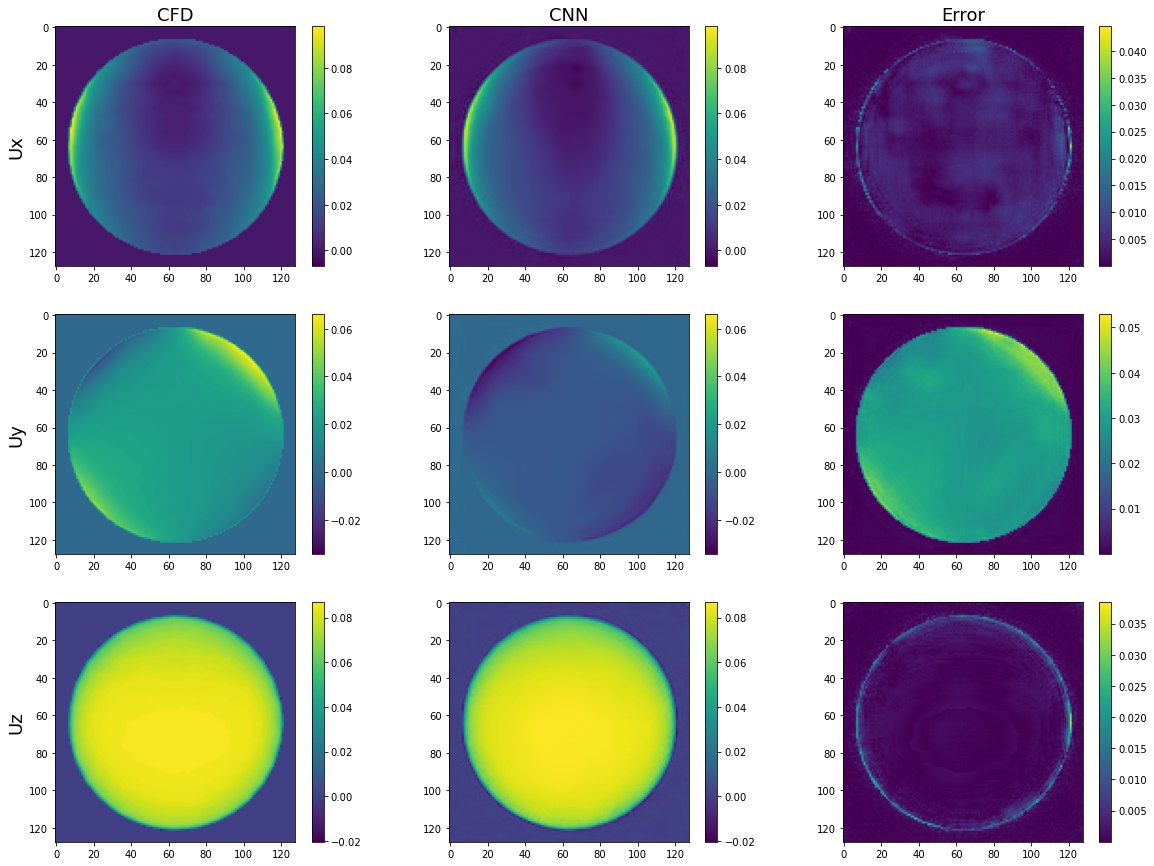

In [31]:
visualize(test_y.cpu().detach().numpy(),
          out.cpu().detach().numpy(),
          error.cpu().detach().numpy())

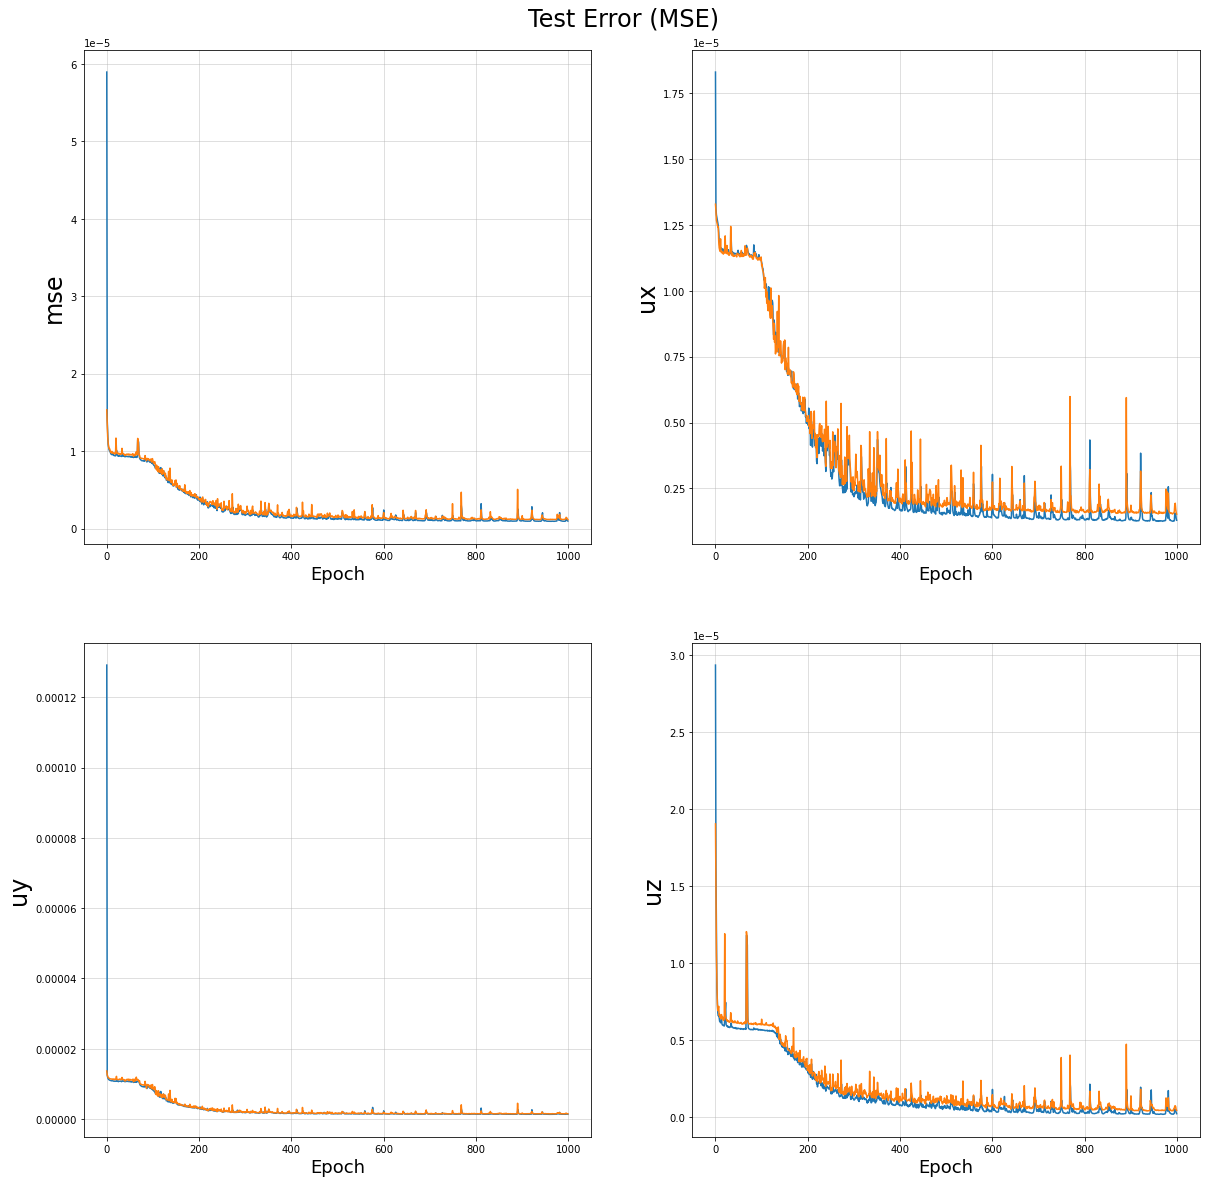

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
fig.suptitle('Test Error (MSE)', y=0.91, fontsize=24)

curve2plot = list(curves.keys())[2:]

for i in range(4):
    axs[i//2][i%2].plot(curves[curve2plot[i*2]], label='train')
    axs[i//2][i%2].plot(curves[curve2plot[i*2+1]], label='test')
    axs[i//2][i%2].grid(alpha=0.5)
#     axs[i//2][i%2].set_title(curve2plot[i*2].split('_')[1], fontsize=24)
    axs[i//2][i%2].set_ylabel(curve2plot[i*2].split('_')[1], fontsize=24)
    axs[i//2][i%2].set_xlabel('Epoch', fontsize=18)

plt.savefig(simulation_directory + 'MSE_ModelV.png')

## Model P

##### "Pressure+Velocity to Pressure"

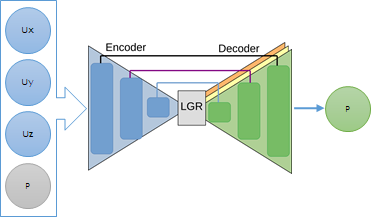

In [33]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, filters=[16, 32, 64], layers=2,
                 weight_norm=True, batch_norm=True, activation=nn.ReLU, final_activation=None):
        super().__init__()
        assert len(filters) > 0
        self.final_activation = final_activation
        self.encoder = create_encoder(in_channels, filters, kernel_size, weight_norm, batch_norm, activation, layers)
        self.decoder = create_decoder(out_channels, filters, kernel_size, weight_norm, batch_norm, activation, layers)

    def encode(self, x):
        tensors = []
        indices = []
        sizes = []
        for encoder in self.encoder:
            x = encoder(x)
            sizes.append(x.size())
            tensors.append(x)
            x, ind = F.max_pool2d(x, 2, 2, return_indices=True)
            indices.append(ind)
        return x, tensors, indices, sizes

    def decode(self, x, tensors, indices, sizes):
        for decoder in self.decoder:
            tensor = tensors.pop()
            size = sizes.pop()
            ind = indices.pop()
            x = F.max_unpool2d(x, ind, 2, 2, output_size=size)
            x = torch.cat([tensor, x], dim=1)
            x = decoder(x)
        return x

    def forward(self, x):
        x, tensors, indices, sizes = self.encode(x)
        x = self.decode(x, tensors, indices, sizes)
        if self.final_activation is not None:
            x = self.final_activation(x)
        return x

In [34]:
# def loss_func(model, batch):
#     x, y = batch
#     output = model(x)
    
#     mae_loss = nn.L1Loss()
    
#     loss = 0
    
#     for i in range(len(y[0])):
#         loss += mae_loss(output[:,i,:,:], y[:,i,:,:])
        
#     loss = (loss)/channels_weights
    
#     return torch.sum(loss), output

In [35]:
DATA_X_PATH = "D:/DataScience/FinalProject/dataX_model_P.pkl"
DATA_Y_PATH = "D:/DataScience/FinalProject/dataY_model_P.pkl"

# Loading dataset
x = pickle.load(open(DATA_X_PATH, "rb"))
y = pickle.load(open(DATA_Y_PATH, "rb"))

assert len(x) == len(y)

# Shuffling dataset
dataset_size = len(x)
indices = list(range(dataset_size))
np.random.shuffle(indices)
x = np.array(x)[indices]
y = np.array(y)[indices]

In [36]:
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)

x_Ns, x_Nc, x_Nx, x_Ny = x.shape
y_Ns, y_Nc, y_Nx, y_Ny = y.shape

# channels_weights = torch.sqrt(torch.mean(y.permute(0, 2, 3, 1)\
#                                          .reshape((y_Ns*y_Nx*y_Ny, y_Nc)) ** 2, dim=0)).view(1, -1, 1, 1).to(device)

# print(channels_weights)

channels_weights = 1

In [37]:
# Spliting dataset into 70% train and 30% test
train_data, test_data = split_tensors(x, y, ratio=0.7)

train_dataset, test_dataset = TensorDataset(*train_data), TensorDataset(*test_data)        
test_x, test_y = test_dataset[:]

In [38]:
simulation_directory = "./Run/"
if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)

In [39]:
config = {}        
train_loss_curve = []
test_loss_curve = []

train_mse_curve = []
test_mse_curve = []

train_p_curve = []
test_p_curve = []

def after_epoch(scope):
    train_loss_curve.append(scope["train_loss"])
    test_loss_curve.append(scope["val_loss"])
    
    train_mse_curve.append(scope["train_metrics"]["mse"])
    test_mse_curve.append(scope["val_metrics"]["mse"])
    
    train_p_curve.append(scope["train_metrics"]["p"])
    test_p_curve.append(scope["val_metrics" ]["p"])

### Training model

In [40]:
# Learning parameters

lr = 0.0001
kernel_size = 9
filters = [8, 16, 32, 32]
bn = False
wn = False
wd = 0.005

model = UNet(x_Nc,
             y_Nc,
             filters=filters,
             kernel_size=kernel_size,
             batch_norm=bn,
             weight_norm=wn,
             activation=nn.ReLU)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

BATCH_SIZE = 64
EPOCHS = 1000

In [41]:
mse_loss = nn.MSELoss()

model_p, train_metrics, train_loss, test_metrics, test_loss = train_model(model,
                                                                          loss_func,
                                                                          train_dataset,
                                                                          test_dataset,
                                                                          optimizer,
                                                                          epochs=EPOCHS,
                                                                          batch_size=BATCH_SIZE,
                                                                          device=device,
                                                                          m_mse_name="Total MSE",
#                                                                           m_mse_on_batch=lambda scope: float(torch.sum((scope["output"] - scope["batch"][1]) ** 2)),
                                                                          m_mse_on_batch=lambda scope: mse_loss(scope["output"], scope["batch"][1]).item(),
                                                                          m_mse_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
                                                                          m_p_name="P MSE",
#                                                                           m_ux_on_batch=lambda scope: float(torch.sum((scope["output"][:,0,:,:] - scope["batch"][1][:,0,:,:]) ** 2)),
                                                                          m_p_on_batch=lambda scope: mse_loss(scope["output"][:,0,:,:], scope["batch"][1][:,0,:,:]).item(),
                                                                          m_p_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
                                                                          patience=25,
                                                                          after_epoch=after_epoch)

metrics = {}
metrics["train_metrics"] = train_metrics
metrics["train_loss"] = train_loss
metrics["test_metrics"] = test_metrics
metrics["test_loss"] = test_loss

curves = {}
curves["train_loss_curve"] = train_loss_curve
curves["test_loss_curve"] = test_loss_curve

curves["train_mse_curve"] = train_mse_curve
curves["test_mse_curve"] = test_mse_curve

curves["train_p_curve"] = train_p_curve
curves["test_p_curve"] = test_p_curve

config["metrics"] = metrics
config["curves"] = curves

with open(simulation_directory + "results_ModelP.json", "w") as file:
    json.dump(config, file)

torch.save(model_p.state_dict(), simulation_directory + 'model_p.pth')

out = model_p(test_x[:10].to(device))
error = torch.abs(out.cpu() - test_y[:10].cpu())

Epoch #1
	Train Loss = 0.5376181821338832
	Train Total MSE = 0.00012751854414940305
	Train P MSE = 0.00012751854414940305
	Validation Loss = 0.16083552036434412
	Validation Total MSE = 8.895769931656201e-05
	Validation P MSE = 8.895769931656201e-05
Model saved!
Epoch #2
	Train Loss = 0.3375709871761501
	Train Total MSE = 8.006901972868835e-05
	Train P MSE = 8.006901972868835e-05
	Validation Loss = 0.126661621266976
	Validation Total MSE = 7.005620645297345e-05
	Validation P MSE = 7.005620645297345e-05
Model saved!
Epoch #3
	Train Loss = 0.28365267463959754
	Train Total MSE = 6.728004616688746e-05
	Train P MSE = 6.728004616688746e-05
	Validation Loss = 0.1211570508312434
	Validation Total MSE = 6.701164315887356e-05
	Validation P MSE = 6.701164315887356e-05
Model saved!
Epoch #4
	Train Loss = 0.2577764601446688
	Train Total MSE = 6.114242413298597e-05
	Train P MSE = 6.114242413298597e-05
	Validation Loss = 0.1093236138112843
	Validation Total MSE = 6.046660055933866e-05
	Validation P MS

	Train Loss = 0.10301038040779531
	Train Total MSE = 2.443320218401217e-05
	Train P MSE = 2.443320218401217e-05
	Validation Loss = 0.05004715593531728
	Validation Total MSE = 2.7680949079268405e-05
	Validation P MSE = 2.7680949079268405e-05
Epoch #34
	Train Loss = 0.1034293711418286
	Train Total MSE = 2.453258328791001e-05
	Train P MSE = 2.453258328791001e-05
	Validation Loss = 0.04458081582561135
	Validation Total MSE = 2.465753087699743e-05
	Validation P MSE = 2.465753087699743e-05
Model saved!
Epoch #35
	Train Loss = 0.1005310716573149
	Train Total MSE = 2.3845130848509226e-05
	Train P MSE = 2.3845130848509226e-05
	Validation Loss = 0.049778717337176204
	Validation Total MSE = 2.7532476403305423e-05
	Validation P MSE = 2.7532476403305423e-05
Epoch #36
	Train Loss = 0.09927709982730448
	Train Total MSE = 2.3547699200024783e-05
	Train P MSE = 2.3547699200024783e-05
	Validation Loss = 0.044818393769674
	Validation Total MSE = 2.4788934607120577e-05
	Validation P MSE = 2.478893460712057

	Validation Loss = 0.0366437011398375
	Validation Total MSE = 2.0267533816281805e-05
	Validation P MSE = 2.0267533816281805e-05
Epoch #66
	Train Loss = 0.06817077239975333
	Train Total MSE = 1.616953804548229e-05
	Train P MSE = 1.616953804548229e-05
	Validation Loss = 0.03663842484820634
	Validation Total MSE = 2.0264615513388462e-05
	Validation P MSE = 2.0264615513388462e-05
Epoch #67
	Train Loss = 0.06845514057204127
	Train Total MSE = 1.623698780171757e-05
	Train P MSE = 1.623698780171757e-05
	Validation Loss = 0.036825803050305694
	Validation Total MSE = 2.0368253899505362e-05
	Validation P MSE = 2.0368253899505362e-05
Epoch #68
	Train Loss = 0.06841954350238666
	Train Total MSE = 1.622854447400063e-05
	Train P MSE = 1.622854447400063e-05
	Validation Loss = 0.0414975747698918
	Validation Total MSE = 2.2952198434674667e-05
	Validation P MSE = 2.2952198434674667e-05
Epoch #69
	Train Loss = 0.06841214135056362
	Train Total MSE = 1.6226788745389853e-05
	Train P MSE = 1.6226788745389853

	Train Loss = 0.05018548923544586
	Train Total MSE = 1.1903579040665527e-05
	Train P MSE = 1.1903579040665527e-05
	Validation Loss = 0.02861586754443124
	Validation Total MSE = 1.5827360367495155e-05
	Validation P MSE = 1.5827360367495155e-05
Model saved!
Epoch #99
	Train Loss = 0.05082345940172672
	Train Total MSE = 1.2054900237601216e-05
	Train P MSE = 1.2054900237601216e-05
	Validation Loss = 0.030702059797476977
	Validation Total MSE = 1.6981227764091247e-05
	Validation P MSE = 1.6981227764091247e-05
Epoch #100
	Train Loss = 0.0516782880295068
	Train Total MSE = 1.2257658451021537e-05
	Train P MSE = 1.2257658451021537e-05
	Validation Loss = 0.028559771366417408
	Validation Total MSE = 1.5796333720363612e-05
	Validation P MSE = 1.5796333720363612e-05
Model saved!
Epoch #101
	Train Loss = 0.048418625665362924
	Train Total MSE = 1.1484493753643957e-05
	Train P MSE = 1.1484493753643957e-05
	Validation Loss = 0.02905132994055748
	Validation Total MSE = 1.6068213462697723e-05
	Validation

	Train Loss = 0.04527561197755858
	Train Total MSE = 1.0738997148377274e-05
	Train P MSE = 1.0738997148377274e-05
	Validation Loss = 0.0308265364728868
	Validation Total MSE = 1.705007548279137e-05
	Validation P MSE = 1.705007548279137e-05
Epoch #131
	Train Loss = 0.040454491041600704
	Train Total MSE = 9.595467514611172e-06
	Train P MSE = 9.595467514611172e-06
	Validation Loss = 0.025827116856817156
	Validation Total MSE = 1.4284909765938693e-05
	Validation P MSE = 1.4284909765938693e-05
Model saved!
Epoch #132
	Train Loss = 0.03988412662874907
	Train Total MSE = 9.460181837938584e-06
	Train P MSE = 9.460181837938584e-06
	Validation Loss = 0.027161511417943984
	Validation Total MSE = 1.5022959855057513e-05
	Validation P MSE = 1.5022959855057513e-05
Epoch #133
	Train Loss = 0.041404135583434254
	Train Total MSE = 9.820715271213058e-06
	Train P MSE = 9.820715271213058e-06
	Validation Loss = 0.026282987790182233
	Validation Total MSE = 1.4537050768906103e-05
	Validation P MSE = 1.4537050

	Validation Loss = 0.02347679331433028
	Validation Total MSE = 1.2984952054386217e-05
	Validation P MSE = 1.2984952054386217e-05
Epoch #163
	Train Loss = 0.036605466419132426
	Train Total MSE = 8.68251101023065e-06
	Train P MSE = 8.68251101023065e-06
	Validation Loss = 0.023822671733796597
	Validation Total MSE = 1.3176256489931745e-05
	Validation P MSE = 1.3176256489931745e-05
Epoch #164
	Train Loss = 0.03126436908496544
	Train Total MSE = 7.415647316168272e-06
	Train P MSE = 7.415647316168272e-06
	Validation Loss = 0.023357061436399817
	Validation Total MSE = 1.291872867057512e-05
	Validation P MSE = 1.291872867057512e-05
Epoch #165
	Train Loss = 0.03355936807929538
	Train Total MSE = 7.960001916341409e-06
	Train P MSE = 7.960001916341409e-06
	Validation Loss = 0.023001894645858556
	Validation Total MSE = 1.2722286861647432e-05
	Validation P MSE = 1.2722286861647432e-05
Model saved!
Epoch #166
	Train Loss = 0.03455112603842281
	Train Total MSE = 8.195238623914328e-06
	Train P MSE = 8

	Train Loss = 0.03279862244380638
	Train Total MSE = 7.779559403179882e-06
	Train P MSE = 7.779559403179882e-06
	Validation Loss = 0.02240947011159733
	Validation Total MSE = 1.2394618424556045e-05
	Validation P MSE = 1.2394618424556045e-05
Epoch #196
	Train Loss = 0.028928977699251845
	Train Total MSE = 6.861711978000912e-06
	Train P MSE = 6.861711978000912e-06
	Validation Loss = 0.022636690526269376
	Validation Total MSE = 1.2520293432671114e-05
	Validation P MSE = 1.2520293432671114e-05
Epoch #197
	Train Loss = 0.027180495351785794
	Train Total MSE = 6.4469865635165545e-06
	Train P MSE = 6.4469865635165545e-06
	Validation Loss = 0.022026038670446724
	Validation Total MSE = 1.2182543512415222e-05
	Validation P MSE = 1.2182543512415222e-05
Epoch #198
	Train Loss = 0.02638389079947956
	Train Total MSE = 6.258038614677314e-06
	Train P MSE = 6.258038614677314e-06
	Validation Loss = 0.02197046997025609
	Validation Total MSE = 1.2151808611867307e-05
	Validation P MSE = 1.2151808611867307e-

	Validation Loss = 0.021173174551222473
	Validation Total MSE = 1.1710826632313315e-05
	Validation P MSE = 1.1710826632313315e-05
Epoch #228
	Train Loss = 0.026344280544435605
	Train Total MSE = 6.248643392892696e-06
	Train P MSE = 6.248643392892696e-06
	Validation Loss = 0.020925725082634017
	Validation Total MSE = 1.1573962988182532e-05
	Validation P MSE = 1.1573962988182532e-05
Epoch #229
	Train Loss = 0.024625711725093424
	Train Total MSE = 5.841013217526903e-06
	Train P MSE = 5.841013217526903e-06
	Validation Loss = 0.02011926844716072
	Validation Total MSE = 1.1127913964137568e-05
	Validation P MSE = 1.1127913964137568e-05
Epoch #230
	Train Loss = 0.02584442382794805
	Train Total MSE = 6.130081553118608e-06
	Train P MSE = 6.130081553118608e-06
	Validation Loss = 0.02158594090724364
	Validation Total MSE = 1.1939126607988738e-05
	Validation P MSE = 1.1939126607988738e-05
Epoch #231
	Train Loss = 0.02383000304689631
	Train Total MSE = 5.652277762546563e-06
	Train P MSE = 5.65227776

	Train Loss = 0.02262139756930992
	Train Total MSE = 5.365606634086793e-06
	Train P MSE = 5.365606634086793e-06
	Validation Loss = 0.01930361828999594
	Validation Total MSE = 1.0676780027652622e-05
	Validation P MSE = 1.0676780027652622e-05
Epoch #261
	Train Loss = 0.021486984798684716
	Train Total MSE = 5.096533396272466e-06
	Train P MSE = 5.096533396272466e-06
	Validation Loss = 0.021415843832073733
	Validation Total MSE = 1.1845046367297418e-05
	Validation P MSE = 1.1845046367297418e-05
Epoch #262
	Train Loss = 0.025028383708558977
	Train Total MSE = 5.936523650037708e-06
	Train P MSE = 5.936523650037708e-06
	Validation Loss = 0.022422076552174985
	Validation Total MSE = 1.240159101337112e-05
	Validation P MSE = 1.240159101337112e-05
Epoch #263
	Train Loss = 0.025634061690652743
	Train Total MSE = 6.080185410496381e-06
	Train P MSE = 6.080185410496381e-06
	Validation Loss = 0.021218750276602805
	Validation Total MSE = 1.1736034445023676e-05
	Validation P MSE = 1.1736034445023676e-05

	Validation Loss = 0.018200879858341068
	Validation Total MSE = 1.0066858328728468e-05
	Validation P MSE = 1.0066858328728468e-05
Epoch #293
	Train Loss = 0.01730910195328761
	Train Total MSE = 4.105574467098579e-06
	Train P MSE = 4.105574467098579e-06
	Validation Loss = 0.019340624567121267
	Validation Total MSE = 1.0697248101283886e-05
	Validation P MSE = 1.0697248101283886e-05
Epoch #294
	Train Loss = 0.017160643488750793
	Train Total MSE = 4.070361358811858e-06
	Train P MSE = 4.070361358811858e-06
	Validation Loss = 0.018625489727128297
	Validation Total MSE = 1.0301708919871845e-05
	Validation P MSE = 1.0301708919871845e-05
Epoch #295
	Train Loss = 0.019297148668556474
	Train Total MSE = 4.5771225494678546e-06
	Train P MSE = 4.5771225494678546e-06
	Validation Loss = 0.018425843270961195
	Validation Total MSE = 1.0191284995000662e-05
	Validation P MSE = 1.0191284995000662e-05
Epoch #296
	Train Loss = 0.016818410702398978
	Train Total MSE = 3.989186599240745e-06
	Train P MSE = 3.989

	Train Loss = 0.014960934247937985
	Train Total MSE = 3.548608692584911e-06
	Train P MSE = 3.548608692584911e-06
	Validation Loss = 0.017578323924681172
	Validation Total MSE = 9.722524294624542e-06
	Validation P MSE = 9.722524294624542e-06
Epoch #326
	Train Loss = 0.015332100403611548
	Train Total MSE = 3.6366462057902155e-06
	Train P MSE = 3.6366462057902155e-06
	Validation Loss = 0.01818097525392659
	Validation Total MSE = 1.0055849144870901e-05
	Validation P MSE = 1.0055849144870901e-05
Epoch #327
	Train Loss = 0.02053399704163894
	Train Total MSE = 4.870492656935233e-06
	Train P MSE = 4.870492656935233e-06
	Validation Loss = 0.017701908654998988
	Validation Total MSE = 9.790878680862272e-06
	Validation P MSE = 9.790878680862272e-06
Epoch #328
	Train Loss = 0.02140878349018749
	Train Total MSE = 5.077984698811074e-06
	Train P MSE = 5.077984698811074e-06
	Validation Loss = 0.020464793691644445
	Validation Total MSE = 1.1319023059537857e-05
	Validation P MSE = 1.1319023059537857e-05


	Validation Loss = 0.018895646324381232
	Validation Total MSE = 1.045113181658254e-05
	Validation P MSE = 1.045113181658254e-05
Epoch #358
	Train Loss = 0.015163565694820136
	Train Total MSE = 3.5966711799858006e-06
	Train P MSE = 3.5966711799858006e-06
	Validation Loss = 0.018517064483603463
	Validation Total MSE = 1.0241739205532889e-05
	Validation P MSE = 1.0241739205532889e-05
Epoch #359
	Train Loss = 0.015046213520690799
	Train Total MSE = 3.56883622407277e-06
	Train P MSE = 3.56883622407277e-06
	Validation Loss = 0.017339561163680628
	Validation Total MSE = 9.590465245398577e-06
	Validation P MSE = 9.590465245398577e-06
Epoch #360
	Train Loss = 0.014041361966519617
	Train Total MSE = 3.3304938250758104e-06
	Train P MSE = 3.3304938250758104e-06
	Validation Loss = 0.01744959532516077
	Validation Total MSE = 9.651324847987153e-06
	Validation P MSE = 9.651324847987153e-06
Epoch #361
	Train Loss = 0.01526115472370293
	Train Total MSE = 3.6198184828517386e-06
	Train P MSE = 3.619818482

	Train Loss = 0.0129709121392807
	Train Total MSE = 3.0765920633967502e-06
	Train P MSE = 3.0765920633967502e-06
	Validation Loss = 0.016433563694590703
	Validation Total MSE = 9.089360450547955e-06
	Validation P MSE = 9.089360450547955e-06
Model saved!
Epoch #391
	Train Loss = 0.012559149938169867
	Train Total MSE = 2.9789255071560407e-06
	Train P MSE = 2.9789255071560407e-06
	Validation Loss = 0.016703155357390642
	Validation Total MSE = 9.238470883512523e-06
	Validation P MSE = 9.238470883512523e-06
Epoch #392
	Train Loss = 0.01288751074753236
	Train Total MSE = 3.0568099496044496e-06
	Train P MSE = 3.0568099496044496e-06
	Validation Loss = 0.016939862980507314
	Validation Total MSE = 9.369393241431037e-06
	Validation P MSE = 9.369393241431037e-06
Epoch #393
	Train Loss = 0.013090168664348312
	Train Total MSE = 3.1048787154526354e-06
	Train P MSE = 3.1048787154526354e-06
	Validation Loss = 0.016071127756731585
	Validation Total MSE = 8.888898095537382e-06
	Validation P MSE = 8.88889

	Validation Loss = 0.02128849778091535
	Validation Total MSE = 1.1774611604488579e-05
	Validation P MSE = 1.1774611604488579e-05
Epoch #423
	Train Loss = 0.02235702505277004
	Train Total MSE = 5.302899680448302e-06
	Train P MSE = 5.302899680448302e-06
	Validation Loss = 0.01826654453179799
	Validation Total MSE = 1.01031772852865e-05
	Validation P MSE = 1.01031772852865e-05
Epoch #424
	Train Loss = 0.015034993542940356
	Train Total MSE = 3.5661749390275985e-06
	Train P MSE = 3.5661749390275985e-06
	Validation Loss = 0.018179167091147974
	Validation Total MSE = 1.0054849054838481e-05
	Validation P MSE = 1.0054849054838481e-05
Epoch #425
	Train Loss = 0.01263200848188717
	Train Total MSE = 2.996206945419158e-06
	Train P MSE = 2.996206945419158e-06
	Validation Loss = 0.01673866342753172
	Validation Total MSE = 9.25811030283834e-06
	Validation P MSE = 9.25811030283834e-06
Epoch #426
	Train Loss = 0.012270363920833915
	Train Total MSE = 2.9104278749606063e-06
	Train P MSE = 2.91042787496060

	Train Loss = 0.010659575724275783
	Train Total MSE = 2.5283623634430225e-06
	Train P MSE = 2.5283623634430225e-06
	Validation Loss = 0.015786955453222618
	Validation Total MSE = 8.731723148906315e-06
	Validation P MSE = 8.731723148906315e-06
Model saved!
Epoch #456
	Train Loss = 0.010653420496964827
	Train Total MSE = 2.526902394915756e-06
	Train P MSE = 2.526902394915756e-06
	Validation Loss = 0.015707068698247895
	Validation Total MSE = 8.687537996818526e-06
	Validation P MSE = 8.687537996818526e-06
Model saved!
Epoch #457
	Train Loss = 0.010659064224455506
	Train Total MSE = 2.5282410399562393e-06
	Train P MSE = 2.5282410399562393e-06
	Validation Loss = 0.016026073339162394
	Validation Total MSE = 8.86397861679336e-06
	Validation P MSE = 8.86397861679336e-06
Epoch #458
	Train Loss = 0.010377060927567072
	Train Total MSE = 2.4613522124210323e-06
	Train P MSE = 2.4613522124210323e-06
	Validation Loss = 0.015923754981486127
	Validation Total MSE = 8.807386604804274e-06
	Validation P M

	Validation Loss = 0.022174597077537328
	Validation Total MSE = 1.2264710772974185e-05
	Validation P MSE = 1.2264710772974185e-05
Epoch #488
	Train Loss = 0.025047586648724973
	Train Total MSE = 5.941078427116929e-06
	Train P MSE = 5.941078427116929e-06
	Validation Loss = 0.022449215786764398
	Validation Total MSE = 1.241660165197146e-05
	Validation P MSE = 1.241660165197146e-05
Epoch #489
	Train Loss = 0.026377123431302607
	Train Total MSE = 6.256433451447488e-06
	Train P MSE = 6.256433451447488e-06
	Validation Loss = 0.022316662420053035
	Validation Total MSE = 1.2343286736754998e-05
	Validation P MSE = 1.2343286736754998e-05
Epoch #490
	Train Loss = 0.015781763577251695
	Train Total MSE = 3.7433025562741212e-06
	Train P MSE = 3.7433025562741212e-06
	Validation Loss = 0.017729121347656474
	Validation Total MSE = 9.80592994892504e-06
	Validation P MSE = 9.80592994892504e-06
Epoch #491
	Train Loss = 0.014879439506330527
	Train Total MSE = 3.529278820287127e-06
	Train P MSE = 3.52927882

	Train Loss = 0.009662135409598704
	Train Total MSE = 2.2917778485765426e-06
	Train P MSE = 2.2917778485765426e-06
	Validation Loss = 0.015634291601600125
	Validation Total MSE = 8.647285177876175e-06
	Validation P MSE = 8.647285177876175e-06
Epoch #521
	Train Loss = 0.010146185013581999
	Train Total MSE = 2.406590373240512e-06
	Train P MSE = 2.406590373240512e-06
	Validation Loss = 0.015605894732289016
	Validation Total MSE = 8.63157894485012e-06
	Validation P MSE = 8.63157894485012e-06
Epoch #522
	Train Loss = 0.009746146090037655
	Train Total MSE = 2.3117044805592162e-06
	Train P MSE = 2.3117044805592162e-06
	Validation Loss = 0.016367840871680528
	Validation Total MSE = 9.053009331681708e-06
	Validation P MSE = 9.053009331681708e-06
Epoch #523
	Train Loss = 0.01087046776956413
	Train Total MSE = 2.578384195816919e-06
	Train P MSE = 2.578384195816919e-06
	Validation Loss = 0.016193450603168458
	Validation Total MSE = 8.956554537150696e-06
	Validation P MSE = 8.956554537150696e-06
Ep

	Train Loss = 0.011702226227498613
	Train Total MSE = 2.7756703575660847e-06
	Train P MSE = 2.7756703575660847e-06
	Validation Loss = 0.01626138697611168
	Validation Total MSE = 8.99412996466354e-06
	Validation P MSE = 8.99412996466354e-06
Epoch #554
	Train Loss = 0.010248903279716615
	Train Total MSE = 2.4309542883578306e-06
	Train P MSE = 2.4309542883578306e-06
	Validation Loss = 0.015715926798293367
	Validation Total MSE = 8.692437388436597e-06
	Validation P MSE = 8.692437388436597e-06
Epoch #555
	Train Loss = 0.009242370928404853
	Train Total MSE = 2.1922132183123466e-06
	Train P MSE = 2.1922132183123466e-06
	Validation Loss = 0.01569201852544211
	Validation Total MSE = 8.679213786195857e-06
	Validation P MSE = 8.679213786195857e-06
Epoch #556
	Train Loss = 0.008778952615102753
	Train Total MSE = 2.082294263544296e-06
	Train P MSE = 2.082294263544296e-06
	Validation Loss = 0.015157515648752451
	Validation Total MSE = 8.383581664132993e-06
	Validation P MSE = 8.383581664132993e-06
M

	Validation Loss = 0.01563656935468316
	Validation Total MSE = 8.648544997059271e-06
	Validation P MSE = 8.648544997059271e-06
Epoch #586
	Train Loss = 0.008339629122929182
	Train Total MSE = 1.978090399176751e-06
	Train P MSE = 1.978090399176751e-06
	Validation Loss = 0.015152793959714472
	Validation Total MSE = 8.380970110461544e-06
	Validation P MSE = 8.380970110461544e-06
Epoch #587
	Train Loss = 0.008420332982495893
	Train Total MSE = 1.9972326808576595e-06
	Train P MSE = 1.9972326808576595e-06
	Validation Loss = 0.015528115502092987
	Validation Total MSE = 8.588559459122228e-06
	Validation P MSE = 8.588559459122228e-06
Epoch #588
	Train Loss = 0.00826260597386863
	Train Total MSE = 1.9598211512971138e-06
	Train P MSE = 1.9598211512971138e-06
	Validation Loss = 0.014960655564209446
	Validation Total MSE = 8.274698874009649e-06
	Validation P MSE = 8.274698874009649e-06
Model saved!
Epoch #589
	Train Loss = 0.00817117568658432
	Train Total MSE = 1.9381346505181024e-06
	Train P MSE =

	Train Loss = 0.007937058100651484
	Train Total MSE = 1.8826039138167656e-06
	Train P MSE = 1.8826039138167656e-06
	Validation Loss = 0.015155585337197408
	Validation Total MSE = 8.382514013936619e-06
	Validation P MSE = 8.382514013936619e-06
Epoch #619
	Train Loss = 0.008495737965859007
	Train Total MSE = 2.015118113344167e-06
	Train P MSE = 2.015118113344167e-06
	Validation Loss = 0.015194261213764548
	Validation Total MSE = 8.403905538586587e-06
	Validation P MSE = 8.403905538586587e-06
Epoch #620
	Train Loss = 0.008109806280117482
	Train Total MSE = 1.9235783396863097e-06
	Train P MSE = 1.9235783396863097e-06
	Validation Loss = 0.015683089644880965
	Validation Total MSE = 8.674275246062481e-06
	Validation P MSE = 8.674275246062481e-06
Epoch #621
	Train Loss = 0.0081175242739846
	Train Total MSE = 1.9254089833929317e-06
	Train P MSE = 1.9254089833929317e-06
	Validation Loss = 0.01562193245626986
	Validation Total MSE = 8.640449367405896e-06
	Validation P MSE = 8.640449367405896e-06


	Validation Loss = 0.01533901083166711
	Validation Total MSE = 8.483966167957473e-06
	Validation P MSE = 8.483966167957473e-06
Epoch #651
	Train Loss = 0.0077087511017452925
	Train Total MSE = 1.8284513998447088e-06
	Train P MSE = 1.8284513998447088e-06
	Validation Loss = 0.015033060044515878
	Validation Total MSE = 8.314745599842853e-06
	Validation P MSE = 8.314745599842853e-06
Epoch #652
	Train Loss = 0.008581309732107911
	Train Total MSE = 2.0354150218472275e-06
	Train P MSE = 2.0354150218472275e-06
	Validation Loss = 0.015969675790984184
	Validation Total MSE = 8.832785282623995e-06
	Validation P MSE = 8.832785282623995e-06
Epoch #653
	Train Loss = 0.007923475350253284
	Train Total MSE = 1.8793821988266802e-06
	Train P MSE = 1.8793821988266802e-06
	Validation Loss = 0.015380089549580589
	Validation Total MSE = 8.506686697776875e-06
	Validation P MSE = 8.506686697776875e-06
Epoch #654
	Train Loss = 0.009616671908588614
	Train Total MSE = 2.280994285718362e-06
	Train P MSE = 2.280994

	Train Loss = 0.008024233757168986
	Train Total MSE = 1.9032812517004235e-06
	Train P MSE = 1.9032812517004235e-06
	Validation Loss = 0.01525012930505909
	Validation Total MSE = 8.434806031559232e-06
	Validation P MSE = 8.434806031559232e-06
Epoch #684
	Train Loss = 0.007969768012117129
	Train Total MSE = 1.8903624317165866e-06
	Train P MSE = 1.8903624317165866e-06
	Validation Loss = 0.015312030009226874
	Validation Total MSE = 8.46904314669628e-06
	Validation P MSE = 8.46904314669628e-06
Epoch #685
	Train Loss = 0.008622657878731843
	Train Total MSE = 2.0452224570047065e-06
	Train P MSE = 2.0452224570047065e-06
	Validation Loss = 0.015629107860149816
	Validation Total MSE = 8.644418064242154e-06
	Validation P MSE = 8.644418064242154e-06
Epoch #686
	Train Loss = 0.008341376946191303
	Train Total MSE = 1.9785049682616942e-06
	Train P MSE = 1.9785049682616942e-06
	Validation Loss = 0.015079114091349766
	Validation Total MSE = 8.340217970879295e-06
	Validation P MSE = 8.340217970879295e-0

	Validation Loss = 0.014302925410447642
	Validation Total MSE = 7.910910072150244e-06
	Validation P MSE = 7.910910072150244e-06
Model saved!
Epoch #716
	Train Loss = 0.0071616478089708835
	Train Total MSE = 1.6986830666439476e-06
	Train P MSE = 1.6986830666439476e-06
	Validation Loss = 0.014539010866428725
	Validation Total MSE = 8.041488311077835e-06
	Validation P MSE = 8.041488311077835e-06
Epoch #717
	Train Loss = 0.007625065161846578
	Train Total MSE = 1.8086017936068735e-06
	Train P MSE = 1.8086017936068735e-06
	Validation Loss = 0.014626924181357026
	Validation Total MSE = 8.090112932166496e-06
	Validation P MSE = 8.090112932166496e-06
Epoch #718
	Train Loss = 0.00770732837554533
	Train Total MSE = 1.8281139410686268e-06
	Train P MSE = 1.8281139410686268e-06
	Validation Loss = 0.014804579026531428
	Validation Total MSE = 8.188373355382426e-06
	Validation P MSE = 8.188373355382426e-06
Epoch #719
	Train Loss = 0.007642183139978442
	Train Total MSE = 1.812662035099251e-06
	Train P M

	Train Loss = 0.0199256172782043
	Train Total MSE = 4.726190056500071e-06
	Train P MSE = 4.726190056500071e-06
	Validation Loss = 0.019366471678949893
	Validation Total MSE = 1.071154407021565e-05
	Validation P MSE = 1.071154407021565e-05
Epoch #749
	Train Loss = 0.025893525729770772
	Train Total MSE = 6.1417281142720044e-06
	Train P MSE = 6.1417281142720044e-06
	Validation Loss = 0.021884647256229073
	Validation Total MSE = 1.2104340296586877e-05
	Validation P MSE = 1.2104340296586877e-05
Epoch #750
	Train Loss = 0.0246142126416089
	Train Total MSE = 5.8382857309319025e-06
	Train P MSE = 5.8382857309319025e-06
	Validation Loss = 0.019087402208242565
	Validation Total MSE = 1.0557191486859827e-05
	Validation P MSE = 1.0557191486859827e-05
Epoch #751
	Train Loss = 0.01915805958560668
	Train Total MSE = 4.544131780267239e-06
	Train P MSE = 4.544131780267239e-06
	Validation Loss = 0.01705656570266001
	Validation Total MSE = 9.433941207223456e-06
	Validation P MSE = 9.433941207223456e-06
E

	Validation Loss = 0.023825619195122272
	Validation Total MSE = 1.3177886722965858e-05
	Validation P MSE = 1.3177886722965858e-05
Epoch #781
	Train Loss = 0.024427212541922927
	Train Total MSE = 5.793930868577545e-06
	Train P MSE = 5.793930868577545e-06
	Validation Loss = 0.018371212296187878
	Validation Total MSE = 1.0161068747891524e-05
	Validation P MSE = 1.0161068747891524e-05
Epoch #782
	Train Loss = 0.011653888228465803
	Train Total MSE = 2.764204987776519e-06
	Train P MSE = 2.764204987776519e-06
	Validation Loss = 0.015837241109693423
	Validation Total MSE = 8.759536011998574e-06
	Validation P MSE = 8.759536011998574e-06
Epoch #783
	Train Loss = 0.008233799926529173
	Train Total MSE = 1.9529885973740923e-06
	Train P MSE = 1.9529885973740923e-06
	Validation Loss = 0.015250519471010193
	Validation Total MSE = 8.435021831310947e-06
	Validation P MSE = 8.435021831310947e-06
Epoch #784
	Train Loss = 0.00991590840567369
	Train Total MSE = 2.3519706844577066e-06
	Train P MSE = 2.351970

	Train Loss = 0.006243959513085429
	Train Total MSE = 1.4810150647735836e-06
	Train P MSE = 1.4810150647735836e-06
	Validation Loss = 0.01436853791528847
	Validation Total MSE = 7.947200174385216e-06
	Validation P MSE = 7.947200174385216e-06
Epoch #814
	Train Loss = 0.00618164955812972
	Train Total MSE = 1.4662356636930078e-06
	Train P MSE = 1.4662356636930078e-06
	Validation Loss = 0.014094929763814434
	Validation Total MSE = 7.79586823219825e-06
	Validation P MSE = 7.79586823219825e-06
Epoch #815
	Train Loss = 0.005988955883367453
	Train Total MSE = 1.420530332867043e-06
	Train P MSE = 1.420530332867043e-06
	Validation Loss = 0.014287077268818393
	Validation Total MSE = 7.90214450708982e-06
	Validation P MSE = 7.90214450708982e-06
Epoch #816
	Train Loss = 0.006087647569074761
	Train Total MSE = 1.4439391767255126e-06
	Train P MSE = 1.4439391767255126e-06
	Validation Loss = 0.01460850375588052
	Validation Total MSE = 8.079924643739225e-06
	Validation P MSE = 8.079924643739225e-06
Epoc

	Validation Loss = 0.0144079506280832
	Validation Total MSE = 7.96899924119646e-06
	Validation P MSE = 7.96899924119646e-06
Epoch #846
	Train Loss = 0.005780028885055799
	Train Total MSE = 1.370974593229554e-06
	Train P MSE = 1.370974593229554e-06
	Validation Loss = 0.014213979331543669
	Validation Total MSE = 7.861714232048489e-06
	Validation P MSE = 7.861714232048489e-06
Epoch #847
	Train Loss = 0.006995808478677645
	Train Total MSE = 1.659347362115191e-06
	Train P MSE = 1.659347362115191e-06
	Validation Loss = 0.014144219618174247
	Validation Total MSE = 7.823130319786642e-06
	Validation P MSE = 7.823130319786642e-06
Epoch #848
	Train Loss = 0.006062848595320247
	Train Total MSE = 1.438057067201197e-06
	Train P MSE = 1.438057067201197e-06
	Validation Loss = 0.014338157532620244
	Validation Total MSE = 7.930396865387303e-06
	Validation P MSE = 7.930396865387303e-06
Epoch #849
	Train Loss = 0.006035508638888132
	Train Total MSE = 1.4315722578007903e-06
	Train P MSE = 1.431572257800790

	Train Loss = 0.005749262709286995
	Train Total MSE = 1.3636771132084902e-06
	Train P MSE = 1.3636771132084902e-06
	Validation Loss = 0.013850167742930353
	Validation Total MSE = 7.660491008257939e-06
	Validation P MSE = 7.660491008257939e-06
Epoch #879
	Train Loss = 0.005666350734827574
	Train Total MSE = 1.3440110851109048e-06
	Train P MSE = 1.3440110851109048e-06
	Validation Loss = 0.013917711112299003
	Validation Total MSE = 7.697849066537059e-06
	Validation P MSE = 7.697849066537059e-06
Epoch #880
	Train Loss = 0.005695206404197961
	Train Total MSE = 1.3508554089653608e-06
	Train P MSE = 1.3508554089653608e-06
	Validation Loss = 0.014060518326004967
	Validation Total MSE = 7.776835357303633e-06
	Validation P MSE = 7.776835357303633e-06
Epoch #881
	Train Loss = 0.005840512691065669
	Train Total MSE = 1.3853208470269613e-06
	Train P MSE = 1.3853208470269613e-06
	Validation Loss = 0.014167693108902313
	Validation Total MSE = 7.836113445189333e-06
	Validation P MSE = 7.836113445189333

	Validation Loss = 0.01420837570913136
	Validation Total MSE = 7.858614883369115e-06
	Validation P MSE = 7.858614883369115e-06
Epoch #911
	Train Loss = 0.005515227931027766
	Train Total MSE = 1.3081660177959597e-06
	Train P MSE = 1.3081660177959597e-06
	Validation Loss = 0.01381355250487104
	Validation Total MSE = 7.64023921729593e-06
	Validation P MSE = 7.64023921729593e-06
Epoch #912
	Train Loss = 0.005447840158012696
	Train Total MSE = 1.2921822006671478e-06
	Train P MSE = 1.2921822006671478e-06
	Validation Loss = 0.013903335871873423
	Validation Total MSE = 7.689898159222026e-06
	Validation P MSE = 7.689898159222026e-06
Epoch #913
	Train Loss = 0.005817661171022337
	Train Total MSE = 1.3799006572633627e-06
	Train P MSE = 1.3799006572633627e-06
	Validation Loss = 0.014245751386624761
	Validation Total MSE = 7.879287271363253e-06
	Validation P MSE = 7.879287271363253e-06
Epoch #914
	Train Loss = 0.005755936144851148
	Train Total MSE = 1.3652599964068187e-06
	Train P MSE = 1.365259996

	Train Loss = 0.005721357119909953
	Train Total MSE = 1.357058140396099e-06
	Train P MSE = 1.357058140396099e-06
	Validation Loss = 0.013928595129982568
	Validation Total MSE = 7.703868987822217e-06
	Validation P MSE = 7.703868987822217e-06
Epoch #944
	Train Loss = 0.0056419158790959045
	Train Total MSE = 1.3382153413415332e-06
	Train P MSE = 1.3382153413415332e-06
	Validation Loss = 0.014018812144058757
	Validation Total MSE = 7.75376777879356e-06
	Validation P MSE = 7.75376777879356e-06
Epoch #945
	Train Loss = 0.0054199445512495
	Train Total MSE = 1.2855655956474146e-06
	Train P MSE = 1.2855655956474146e-06
	Validation Loss = 0.014042963332030922
	Validation Total MSE = 7.767125736742766e-06
	Validation P MSE = 7.767125736742766e-06
Epoch #946
	Train Loss = 0.005612386790744495
	Train Total MSE = 1.331211288127252e-06
	Train P MSE = 1.331211288127252e-06
	Validation Loss = 0.014472200200543739
	Validation Total MSE = 8.004535509150299e-06
	Validation P MSE = 8.004535509150299e-06
Ep

	Validation Loss = 0.014019731534062885
	Validation Total MSE = 7.754276290963985e-06
	Validation P MSE = 7.754276290963985e-06
Epoch #976
	Train Loss = 0.006166159415442962
	Train Total MSE = 1.4625615311771731e-06
	Train P MSE = 1.4625615311771731e-06
	Validation Loss = 0.014396079233847558
	Validation Total MSE = 7.962433204561703e-06
	Validation P MSE = 7.962433204561703e-06
Epoch #977
	Train Loss = 0.0059260596535750665
	Train Total MSE = 1.4056118722901012e-06
	Train P MSE = 1.4056118722901012e-06
	Validation Loss = 0.013982788674184121
	Validation Total MSE = 7.73384329324343e-06
	Validation P MSE = 7.73384329324343e-06
Epoch #978
	Train Loss = 0.0058426573377801105
	Train Total MSE = 1.385829539321658e-06
	Train P MSE = 1.385829539321658e-06
	Validation Loss = 0.013836313446518034
	Validation Total MSE = 7.652828233693602e-06
	Validation P MSE = 7.652828233693602e-06
Epoch #979
	Train Loss = 0.008387051959289238
	Train Total MSE = 1.9893387000211664e-06
	Train P MSE = 1.9893387

Sampled model number: 3


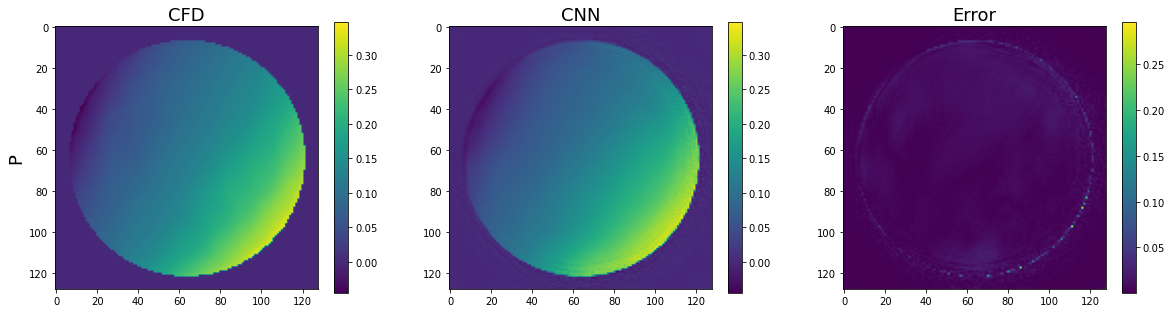

In [42]:
visualize(test_y.cpu().detach().numpy(),
          out.cpu().detach().numpy(),
          error.cpu().detach().numpy())

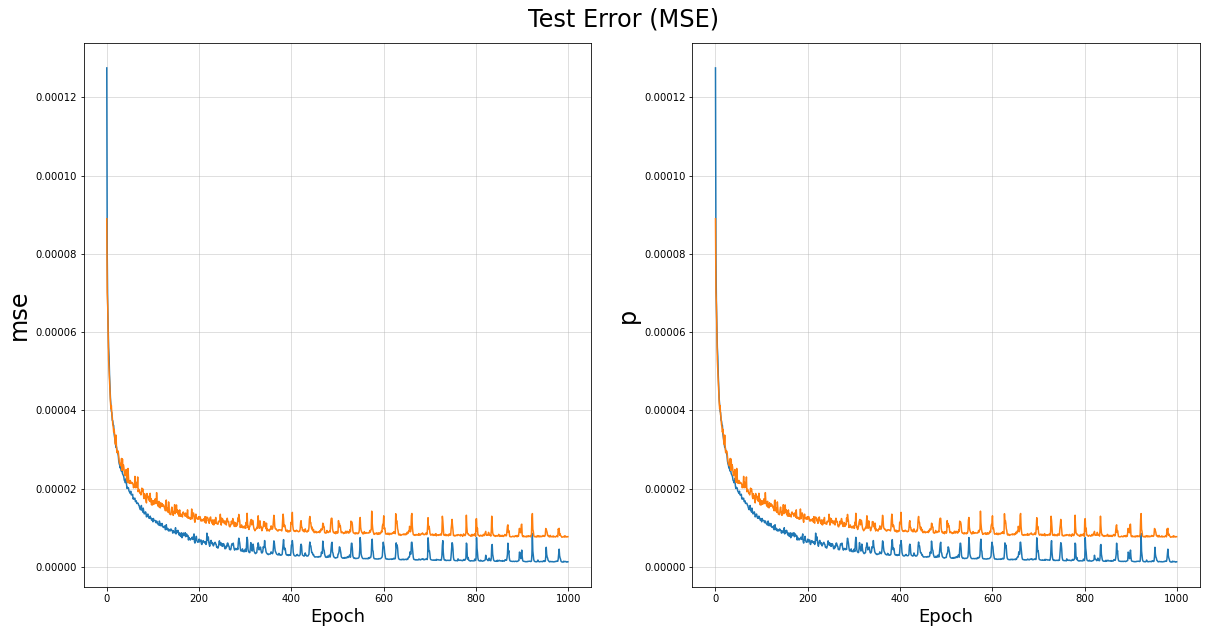

In [43]:
curve2plot = list(curves.keys())[2:]
n_plots = int(len(curve2plot)/2)
n_rows = int(math.ceil(n_plots/2))

fig, axs = plt.subplots(n_rows, 2, figsize=(20, n_rows*10))
fig.suptitle('Test Error (MSE)', y=0.93, fontsize=24)

for i in range(n_plots):
    axs[i%2].plot(curves[curve2plot[i*2]], label='train')
    axs[i%2].plot(curves[curve2plot[i*2+1]], label='test')
    axs[i%2].grid(alpha=0.5)
#     axs[i%2].set_title(curve2plot[i*2].split('_')[1], fontsize=24)
    axs[i%2].set_ylabel(curve2plot[i*2].split('_')[1], fontsize=24)
    axs[i%2].set_xlabel('Epoch', fontsize=18)

plt.savefig(simulation_directory + 'MSE_ModelP.png')

# Inference

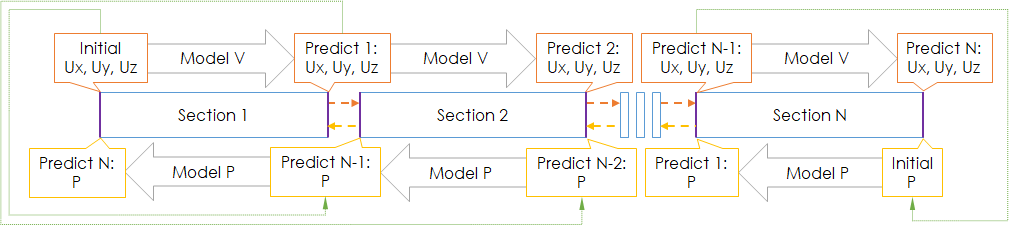

In [44]:
# loading data
df = pd.read_csv(os.path.join('D:/DataScience/FinalProject', 'data.csv'))

# # loading models
# MODEL_PATH = "D:/DataScience/FinalProject/"

# model_v = TheModelClass(*args, **kwargs)
# model_v.load_state_dict(torch.load(MODEL_PATH + 'model_v.pth'))
# model_v.eval()

# model_p = TheModelClass(*args, **kwargs)
# model_p.load_state_dict(torch.load(MODEL_PATH + 'model_p.pth'))
# model_p.eval()

#### Setting pipe param

##### Initial Velocity and Pressure

In [91]:
initial_velocity = []
initial_pressure = []

row = 0

for v in ['UX', 'UY', 'UZ']:
    img, _, _ = get_preprocessed_image(column='inlet-' + v + '_image', row=row)
    initial_velocity.append(img)

img, img_h, img_w = get_preprocessed_image(column='outlet-P_image', row=row)
initial_pressure.append(img)

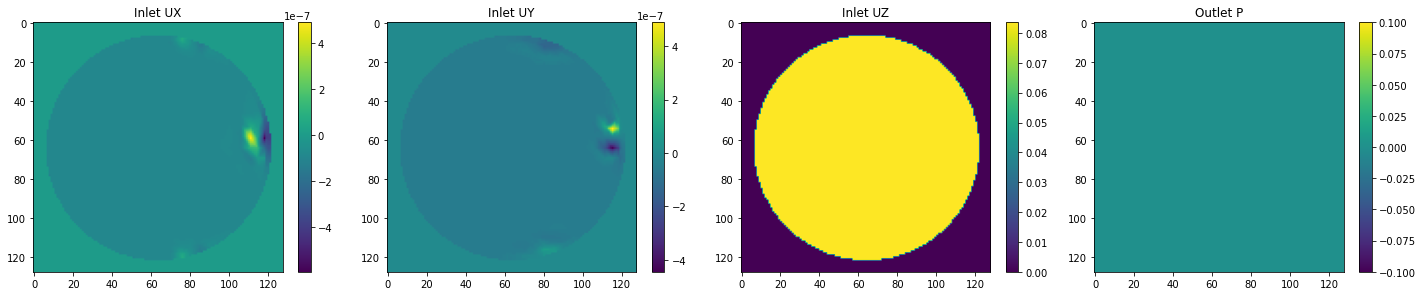

In [92]:
plt.figure(figsize=(20,4), tight_layout=True)

for i in range(len(initial_velocity)+1):
    
    labels = ['UX', 'UY', 'UZ']
    
    if i == len(initial_velocity):
        img2plt = initial_pressure[0]
        title = 'Outlet P'
    else:
        img2plt = initial_velocity[i]
        title = 'Inlet ' + labels[i]
        
    plt.subplot(1, len(initial_velocity)+1, i+1)
    plt.imshow(img2plt)
    plt.title(title)
    plt.colorbar()

##### Pipe geom

In [93]:
'''
Available shapes:
    size = [50, 100],
    shape = [arc45, arc90, line],
    direction = [down, left, right, top]
    ---
    *If shape is "line" then direction can only be "left"
    **First section can only be "left
'''
# Input your geom
## section = [size, shape, direction]
pipe_config = {'section_1':['100','line','left'],
               'section_2':['50','arc45','top'],
               'section_3':['50','line','left'],
               'section_4':['100','arc90','right']}

In [94]:
# Converting to lable
geom_param_converter = {'previous':{'size':{'nothing':0,
                                            '50':1,
                                            '100':2},
                                    'shape':{'nothong':0,
                                             'arc45':1,
                                             'arc90':2,
                                             'line':3},
                                    'direction':{'nothong':0,
                                                 'left':1} },
                        
                        'current':{'size':{'50':0,
                                           '100':1},
                                   'shape':{'arc45':0,
                                            'arc90':1,
                                            'line':2},
                                   'direction':{'down':0,
                                                'left':1,
                                                'right':2,
                                                'top':3} },
                        
                        'next':{'size':{'nothing':0,
                                        '50':1,
                                        '100':2},
                                'shape':{'nothing':0,
                                         'arc45':1,
                                         'arc90':2,
                                         'line':3},
                                'direction':{'nothing':0,
                                             'down':0,
                                             'left':1,
                                             'right':2,
                                             'top':3} }
                       }

for i in pipe_config.keys():
    for j, k in enumerate(geom_param_converter['current'].keys()):
        pipe_config[i][j] = geom_param_converter['current'][k][pipe_config[i][j]]

In [95]:
# preparing geom channels

input_pipe_config = []

for i in range(len(pipe_config)):
    
    i = i+1
    
    section_geom_param = []
    
    s = (img_h, img_w)
    geom_param = np.zeros(s)
    
    # previous
    if i == 1:
        section_geom_param += [0,0,0]
    else:
        section_geom_param += pipe_config['section_'+ str(i-1)]
    
    # current
    section_geom_param += pipe_config['section_'+ str(i)]
    
    # next
    if i == len(pipe_config):
        section_geom_param += [0,0,0]
    else:
        section_geom_param += pipe_config['section_'+ str(i+1)]
        
    
    for (h, w), x in zip(itertools.product(range(img_h), range(img_w)), itertools.cycle(section_geom_param)):
        geom_param.itemset((h, w), x)
    
    input_pipe_config.append(geom_param.astype('float32'))

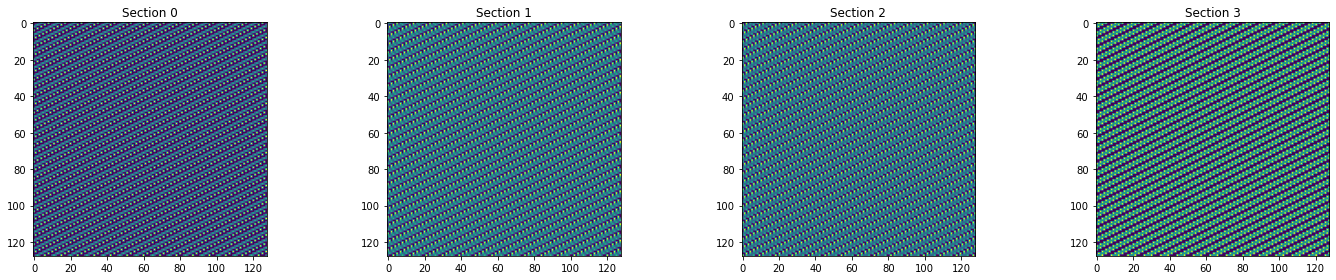

In [96]:
plt.figure(figsize=(20,4), tight_layout=True)

for i in range(len(input_pipe_config)):
    plt.subplot(1, len(input_pipe_config), i+1)
    plt.imshow(input_pipe_config[i])
    plt.title('Section '+ str(i))

### Inferencing

In [161]:
model_v_out_list = []

for section in range(len(pipe_config)):
    
    channels_set = []
    all_sets = []
    
    if section == 0:
        channels_set = initial_velocity.copy()
    else:
        for v in range(len(initial_velocity)):
            channels_set.append(model_v_out[v])
        
    channels_set.append(input_pipe_config[section])
    
    all_sets.append(channels_set)
    
    all_sets = torch.FloatTensor(all_sets)

    # Predicting
    model_v_out = model_v(all_sets.to(device)).cpu().detach().numpy()[0]
    model_v_out_list.append(model_v_out)

In [163]:
f = open(simulation_directory + 'model_v_out.pkl', 'wb')
pickle.dump(model_v_out_list, f)

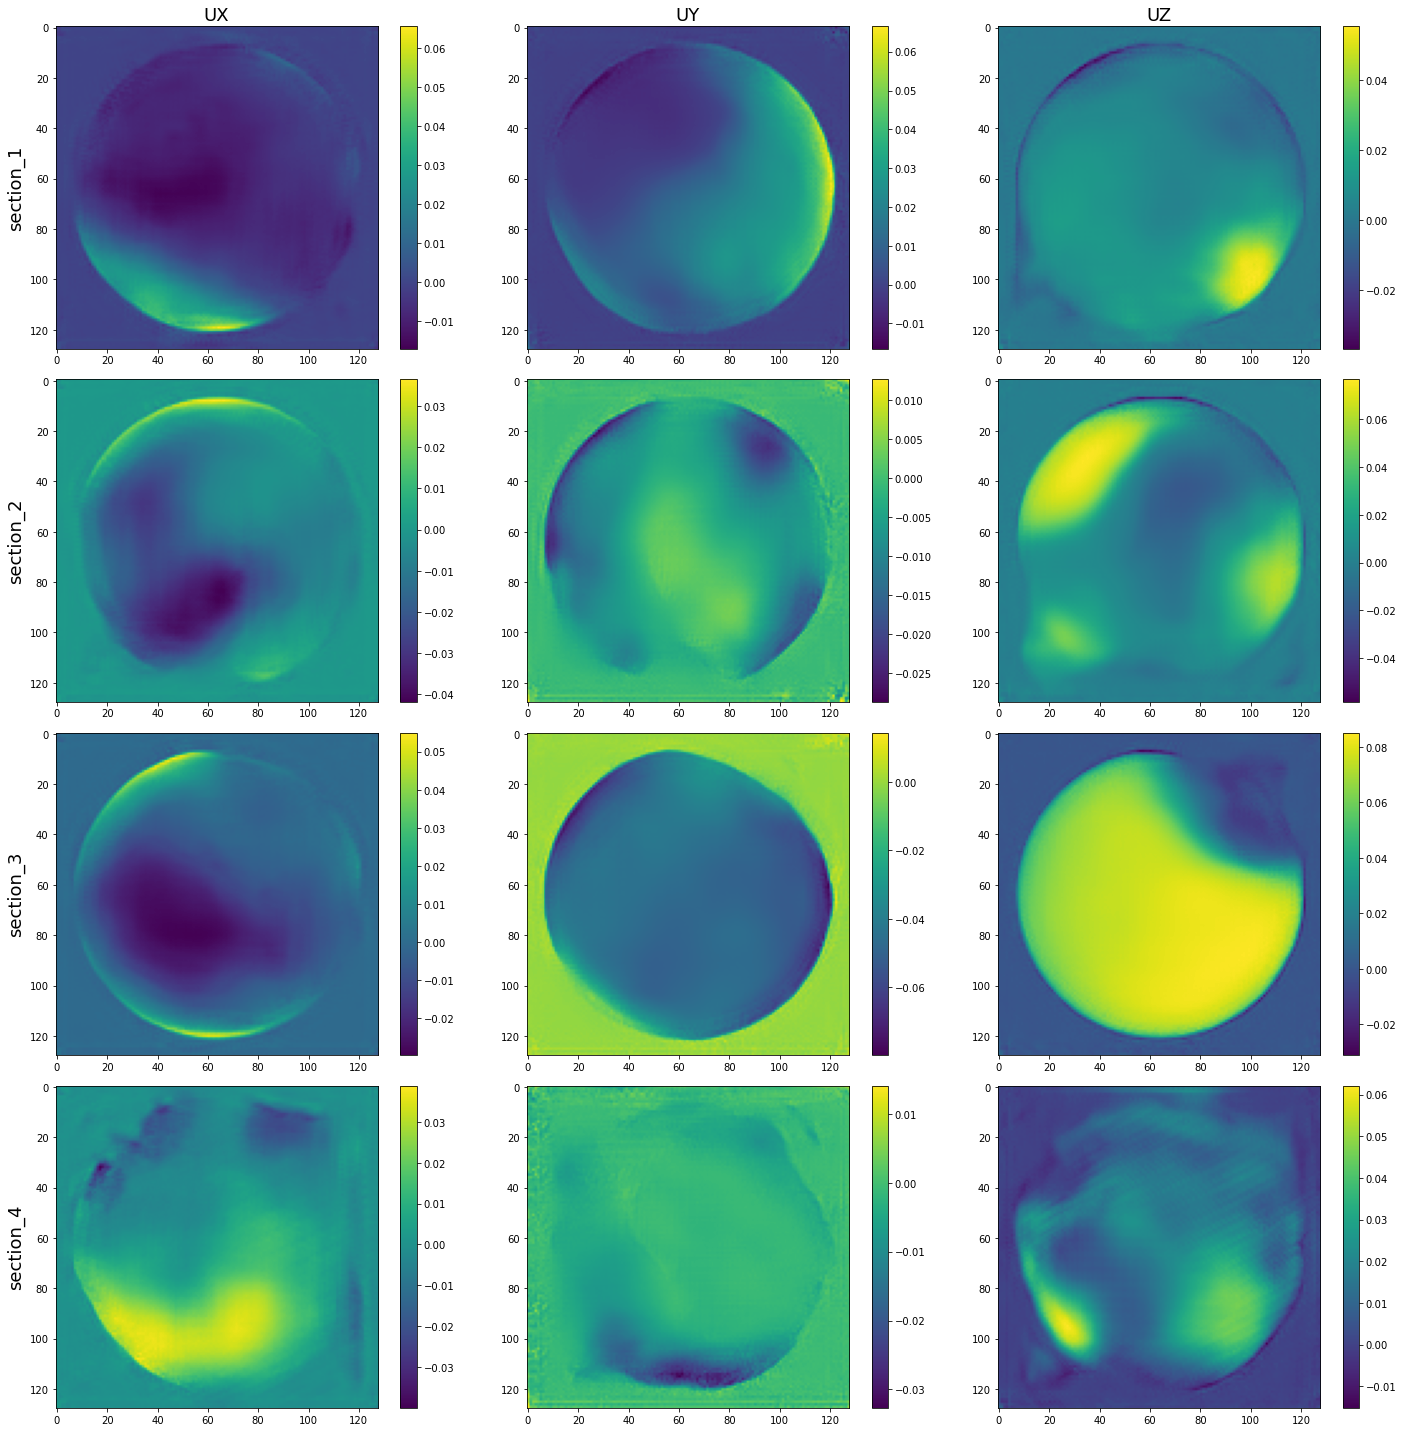

In [196]:
plt.figure(figsize=(20,20), tight_layout=True)

for cnt, (i, j) in enumerate(itertools.product(range(len(pipe_config)), range(3))):
    plt.subplot(len(pipe_config), 3, cnt+1)
    plt.imshow(model_v_out_list[i][j])
    
    if j == 0:
        plt.ylabel(f'{list(pipe_config.keys())[i]}', fontsize=18)
    
    if i == 0:
        plt.title(f'{labels[j]}', fontsize=18)
    
    plt.colorbar()

In [243]:
model_p_out_list = []

for section in range(len(pipe_config)):
    
    channels_set = []
    all_sets = []
    
    if section == 0:
        channels_set = initial_pressure.copy()
    else:
        channels_set.append(model_p_out[0])
    
    if section == len(pipe_config)-1:
        velocity_set = initial_velocity.copy()
    else:
        velocity_set = model_v_out_list[len(pipe_config)-(2+section)].copy()
        
    for v in range(len(initial_velocity)):
        channels_set.append(velocity_set[v]) 
    
    all_sets.append(channels_set)
    
    all_sets = torch.FloatTensor(all_sets)

    # Predicting
    model_p_out = model_p(all_sets.to(device)).cpu().detach().numpy()[0]
    model_p_out_list.append(model_p_out)

In [245]:
f = open(simulation_directory + 'model_p_out.pkl', 'wb')
pickle.dump(model_p_out_list, f)

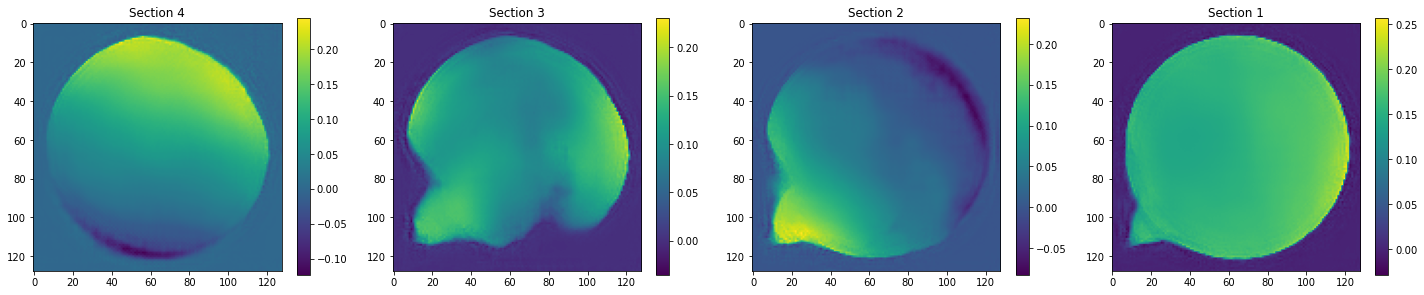

In [256]:
plt.figure(figsize=(20,4), tight_layout=True)

for i in range(len(pipe_config)):
    plt.subplot(1, len(pipe_config), i+1)
    plt.imshow(model_p_out_list[i][0])
    plt.title('Section '+ str(len(pipe_config)-i))
    plt.colorbar()

### CFD results

In [165]:
df_inference = pd.read_csv(os.path.join('D:/DataScience/FinalProject/inference/10-100-50-50-100', '10-100-50-50-100.csv'))
df_inference

description   s0-P_min  \
0  10-100-50-50-100-line-arc45-line-arc90-left-to...  37.754311   

   s0-UMagnitude_min  s0-UX_min  s0-UY_min  s0-UZ_min   s0-P_max  \
0                0.0        0.0        0.0  10.650389  42.437408   

   s0-UMagnitude_max  s0-UX_max  s0-UY_max  s0-UZ_max  s1-P_min  \
0          10.650389        0.0        0.0  10.650389 -4.723748   

   s1-UMagnitude_min  s1-UX_min  s1-UY_min  s1-UZ_min   s1-P_max  \
0         -12.064829 -12.064829  -1.355771  -0.884109  42.437408   

   s1-UMagnitude_max  s1-UX_max  s1-UY_max  s1-UZ_max  s2-P_min  \
0          11.773708   1.419527   8.618194  11.773708 -4.723748   

   s2-UMagnitude_min  s2-UX_min  s2-UY_min  s2-UZ_min   s2-P_max  \
0         -12.064829 -12.064829  -1.355771  -0.884109  42.437408   

   s2-UMagnitude_max  s2-UX_max  s2-UY_max  s2-UZ_max  s3-P_min  \
0          11.773708   1.419527   8.618194  11.773708 -4.723748   

   s3-UMagnitude_min  s3-UX_min  s3-UY_min  s3-UZ_min   s3-P_max  \
0         -12.064829 -12.064829  -1.355771  -0.884109  42.437408   

   s3-UMagnitude_max  s3-UX_max  s3-UY_max  s3-UZ_max  s4-P_min  \
0          11.773708   1.419527   8.618194  11.773708       0.0   

   s4-UMagnitude_min  s4-UX_min  s4-UY_min  s4-UZ_min  s4-P_max  \
0         -12.064829 -12.064829  -1.316668  -0.798943       0.0   

   s4-UMagnitude_max  s4-UX_max  s4-UY_max  s4-UZ_max  
0           0.748225  -2.387443   0.697362   0.748225

In [166]:
IMG_PATH = 'D:\\DataScience\\FinalProject\\inference\\10-100-50-50-100\\10-100-50-50-100-line-arc45-line-arc90-left-top-left-right\\'

img_list = []

for i in ['s0', 's4']:
    img_list += glob.glob(IMG_PATH + i + '*')

for img in img_list:
    new_column = os.path.basename(img).replace('.png', '_image')
    df_inference[new_column] = img

df_inference

description   s0-P_min  \
0  10-100-50-50-100-line-arc45-line-arc90-left-to...  37.754311   

   s0-UMagnitude_min  s0-UX_min  s0-UY_min  s0-UZ_min   s0-P_max  \
0                0.0        0.0        0.0  10.650389  42.437408   

   s0-UMagnitude_max  s0-UX_max  s0-UY_max  s0-UZ_max  s1-P_min  \
0          10.650389        0.0        0.0  10.650389 -4.723748   

   s1-UMagnitude_min  s1-UX_min  s1-UY_min  s1-UZ_min   s1-P_max  \
0         -12.064829 -12.064829  -1.355771  -0.884109  42.437408   

   s1-UMagnitude_max  s1-UX_max  s1-UY_max  s1-UZ_max  s2-P_min  \
0          11.773708   1.419527   8.618194  11.773708 -4.723748   

   s2-UMagnitude_min  s2-UX_min  s2-UY_min  s2-UZ_min   s2-P_max  \
0         -12.064829 -12.064829  -1.355771  -0.884109  42.437408   

   s2-UMagnitude_max  s2-UX_max  s2-UY_max  s2-UZ_max  s3-P_min  \
0          11.773708   1.419527   8.618194  11.773708 -4.723748   

   s3-UMagnitude_min  s3-UX_min  s3-UY_min  s3-UZ_min   s3-P_max  \
0         -12.064829 -12.064829  -1.355771  -0.884109  42.437408   

   s3-UMagnitude_max  s3-UX_max  s3-UY_max  s3-UZ_max  s4-P_min  \
0          11.773708   1.419527   8.618194  11.773708       0.0   

   s4-UMagnitude_min  s4-UX_min  s4-UY_min  s4-UZ_min  s4-P_max  \
0         -12.064829 -12.064829  -1.316668  -0.798943       0.0   

   s4-UMagnitude_max  s4-UX_max  s4-UY_max  s4-UZ_max  \
0           0.748225  -2.387443   0.697362   0.748225   

                                          s0-P_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                 s0-UMagnitude_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                         s0-UX_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                         s0-UY_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                         s0-UZ_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                          s4-P_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                 s4-UMagnitude_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                         s4-UX_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                         s4-UY_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                         s4-UZ_image  
0  D:\DataScience\FinalProject\inference\10-100-5...

In [167]:
inference_image = []

for col in df_inference.columns[-len(img_list):]:
    img, _, _ = get_preprocessed_image(column=col, row=0, ratio=4, df=df_inference, save=False, data_path=DATA_PATH)
    inference_image.append(img)

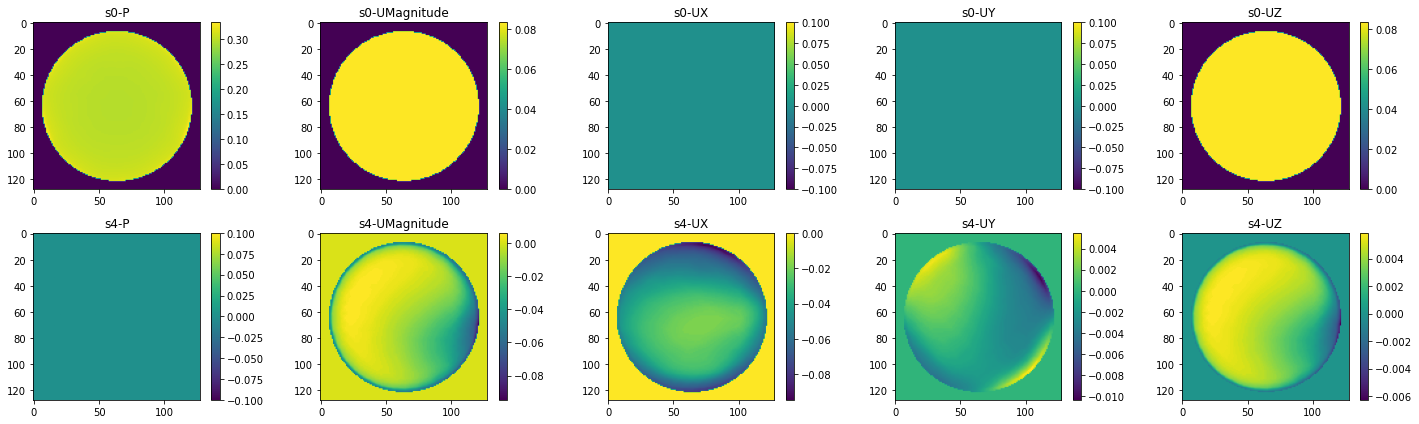

In [168]:
plt.figure(figsize=(20,6), tight_layout=True)

for i, j in enumerate(img_list):
    name = os.path.basename(j).replace('.png', '')
    plt.subplot(2, len(img_list)//2, i+1)
    plt.imshow(inference_image[i])
    plt.title(name)
    plt.colorbar()

# Comparison

In [264]:
model_v_err = []

for v in range(1, 4):
    err = model_v_out_list[-1][-v] - inference_image[-v]
    model_v_err.append(err)

In [265]:
model_p_err = model_p_out_list[-1][0] - inference_image[0]

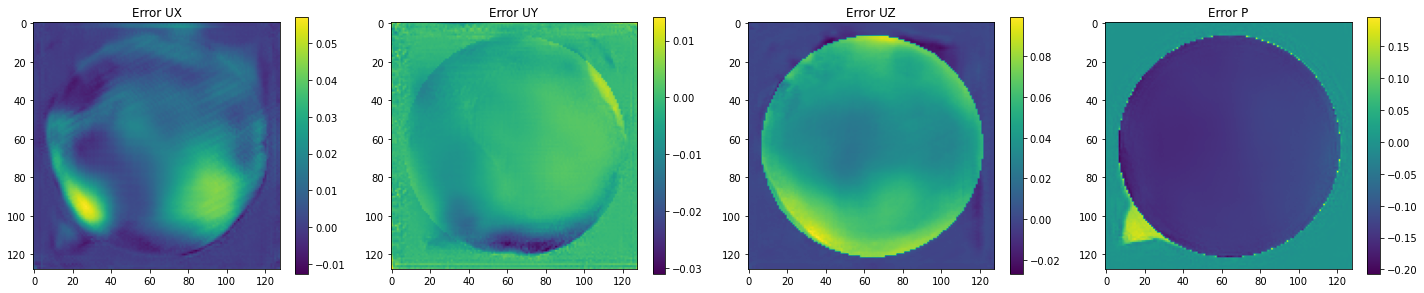

In [269]:
plt.figure(figsize=(20,4), tight_layout=True)

for i in range(len(model_v_err)+1):
    
    if i == len(model_v_err):
        img2plt = model_p_err
        title = 'Error P'
    else:
        img2plt = model_v_err[i]
        title = 'Error ' + labels[i]
        
    plt.subplot(1, len(model_v_err)+1, i+1)
    plt.imshow(img2plt)
    plt.title(title)
    plt.colorbar()